In [2]:
import yfinance
import datetime
from full_fred.fred import Fred
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [7]:

start_date = datetime.datetime(2014,1,1)
end_date = datetime.datetime(2020,1,1)

splt = yfinance.download("SPTL",start_date,end_date)['Close']

os.environ['FRED_API_KEY'] = 'c958545882d597942a61665e3c2ab0bd'
fred = Fred()
fred.env_api_key_found()

[*********************100%%**********************]  1 of 1 completed


True

In [1162]:
EFFR=fred.get_series_df('EFFR')

EFFR.drop(columns=['realtime_start',"realtime_end"],inplace=True)
EFFR=EFFR.loc[(EFFR['date'] >= '2014-01-01') & (EFFR['date'] < "2020-01-01")]

EFFR['date']=pd.to_datetime(EFFR['date'])
EFFR['value'] =((pd.to_numeric(EFFR['value'], errors='coerce')))/100
lst = splt.index.values
EFFR=EFFR.loc[EFFR['date'].isin(lst)]
EFFR.set_index('date', inplace=True)


/var/folders/c0/fnpd65z90_9cvw6ytyjqh0gw0000gn/T/ipykernel_68762/2420359040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EFFR['date']=pd.to_datetime(EFFR['date'])
/var/folders/c0/fnpd65z90_9cvw6ytyjqh0gw0000gn/T/ipykernel_68762/2420359040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EFFR['value'] =((pd.to_numeric(EFFR['value'], errors='coerce')))/100


In [13]:


# plt.plot(splt_return)
# plt.title("SPLT log return")
# plt.xlabel("Date")
# plt.ylabel("Return")
# plt.show()
# # add histogra of return

# plt.plot(pd.to_datetime(EFFR['date']),EFFR['value'])
# plt.title("Daily risk free rate (EFFR)")
# plt.xlabel("Date")
# plt.ylabel("Percentages")
# plt.show()


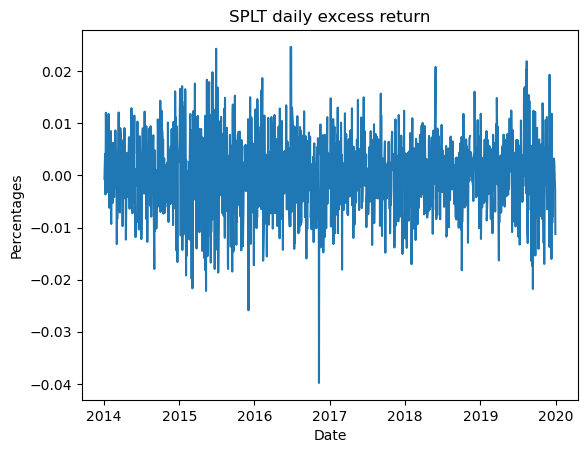

In [1333]:

splt_excess_return= (splt-splt.shift(1))/splt.shift(1)-((EFFR['value']/255).shift(1))
plt.plot(splt_excess_return)
plt.title('SPLT daily excess return' )
plt.xlabel('Date')
plt.ylabel('Percentages')
plt.show()


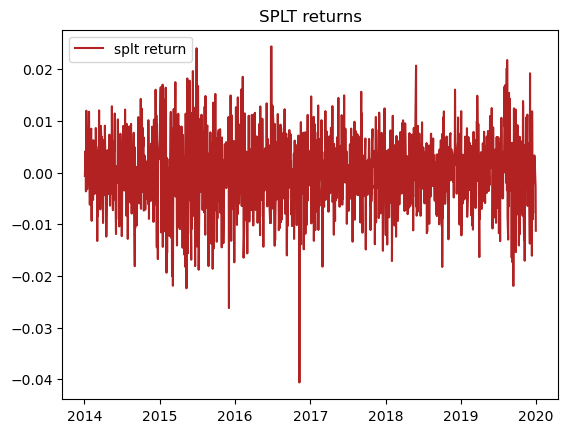

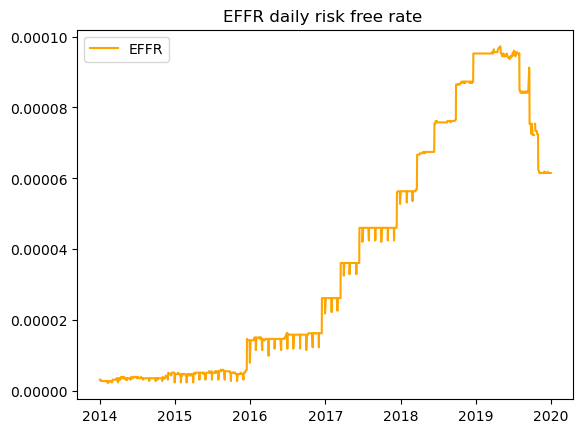

In [1017]:

splt_return = np.log(splt / splt.shift(1))

plt.plot(splt_return,color ='firebrick',label ='splt return')
plt.title("SPLT returns")
plt.legend()
plt.show()


plt.plot(pd.to_datetime(EFFR['date']),EFFR['value'],label ='EFFR',color='orange')
plt.title("EFFR daily risk free rate ")
plt.legend()
plt.show()

In [1336]:

# Train test split
x= len(splt)*70//100
train_set = splt[:x+1]
test_set = splt[x+1:]
train_set_EFFR = EFFR[:x+1]['value']/252
test_set_EFFR=EFFR[x+1:]['value']/252
splt_excess_return_train = splt_excess_return[:x+1]
splt_excess_return_test =splt_excess_return[x+1:]
V0=200000
L =10


Buy and hold benchmark

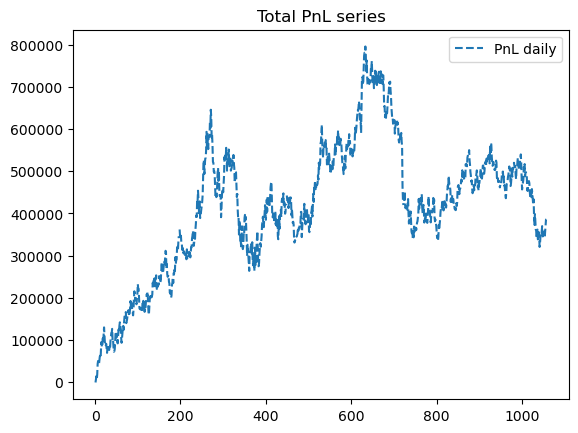

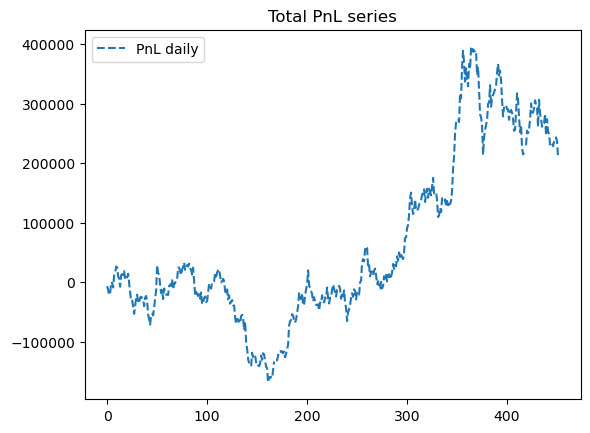

In [1020]:
# Total PnL Buy and hold
theta_S1 =[V0*L/train_set[0]]*len(train_set)*np.array(train_set)
daily_PnL_S1 =splt_excess_return_train*theta_S1

thetaS1_test =[V0*L/test_set[0]]*len(test_set)*np.array(test_set)
daily_PnL_S1_test =splt_excess_return_test*thetaS1_test

t=np.arange(0,len(train_set))

plt.plot(t,np.cumsum(daily_PnL_S1),linestyle ='--',label='PnL daily')
plt.title("Total PnL series")
plt.legend()
plt.show()

t=np.arange(0,len(test_set))

plt.plot(t,np.cumsum(daily_PnL_S1_test),linestyle ='--',label='PnL daily')
plt.title("Total PnL series")
plt.legend()
plt.show()

Trend Following

In [1581]:
#  Trend following 
window = 2
cash2 =[V0*L]*len(train_set)
holding_tick_long_short =[0]*len(train_set)
constrain = V0*L
MA=[train_set[0]]*window
i = window
buy =False
short = False
short_price=0
short_asset =0


while (i < len(train_set)):

    ma =np.sum([train_set[i-x] for x in range(1,window+1)])/window
    MA.append(ma)
    if not buy and not short:
        if train_set[i]> ma:
             # when price moving average excesss, buy
            if cash2[i-1]>constrain:
                holding_tick_long_short [i]=(constrain/train_set[i])
                cash2[i]=cash2[i-1]-constrain
            else:
                holding_tick_long_short [i]=(cash2[i-1]/train_set[i])
                cash2[i]=0
            buy = True
            # print('buy',i,holding_tick[i],train_set[i])
        elif train_set[i] < ma:
            if cash2[i-1]>constrain:
                holding_tick_long_short [i]=-(constrain/train_set[i])
                cash2[i]=cash2[i]-constrain
                short_asset=constrain
            else: 
                holding_tick_long_short [i]=-(cash2[i-1]/train_set[i])
                cash2[i]=0
                short_asset=cash2[-1]
            short_price =train_set[i]
            short =True 
        else:
            holding_tick_long_short [i]=(holding_tick_long_short [i-1])
            cash2[i]=cash2[i-1]

    elif buy:
        if train_set[i] < 1.01*ma:
            holding_tick_long_short [i]=0
            cash2[i]=(holding_tick_long_short [i-1]*train_set[i])+cash2[i-1]
            buy =False
        else:
            if holding_tick_long_short [i-1]*train_set[i]<=constrain:
                holding_tick_long_short [i]=(holding_tick_long_short [i-1])
                cash2[i]=cash2[i-1]
            else:
                holding_tick_long_short [i]=constrain/train_set[i]
                cash2[i]= train_set[i]*(holding_tick_long_short [i-1]-holding_tick_long_short [i])+cash2[i-1]
    elif short: 
        if train_set[i]>= ma:
            holding_tick_long_short [i]=0
            cash2[i]= np.abs(holding_tick_long_short [i-1])*(short_price-train_set[i])+short_asset+cash2[i-1]
            short_price =0
            short = False
            # print('short sell',i,cash[i],train_set[i])
        else:
            if np.abs(holding_tick_long_short [i-1])*(short_price-train_set[i])+short_asset+cash2[i-1] >constrain:
                holding_tick_long_short[i]=-constrain/(2*short_price-train_set[i])
                cash2[i]=cash2[i-1]+(holding_tick_long_short[i-1]-holding_tick_long_short[i])*(short_price-train_set[i])+short_asset*(-holding_tick_long_short[i-1]-(-holding_tick_long_short[i]))/-holding_tick_long_short[i-1]
            else:
                holding_tick_long_short [i]=(holding_tick_long_short [i-1])
                cash2[i]=cash2[i-1]
            # print('short same sell',i,holding_tick[i],train_set[i])
    
    i+=1

# strategy2 = np.array(holding_tick_long_short )*np.array(strategy_price)+cash2
# print((strategy2[-1]-strategy2[29])/strategy2[29])
# print(np.array(holding_tick)[30:50],np.array(strategy_price )[30:50])



Text(0.5, 1.0, 'Rolling 30 days volatility of SPLT train set')

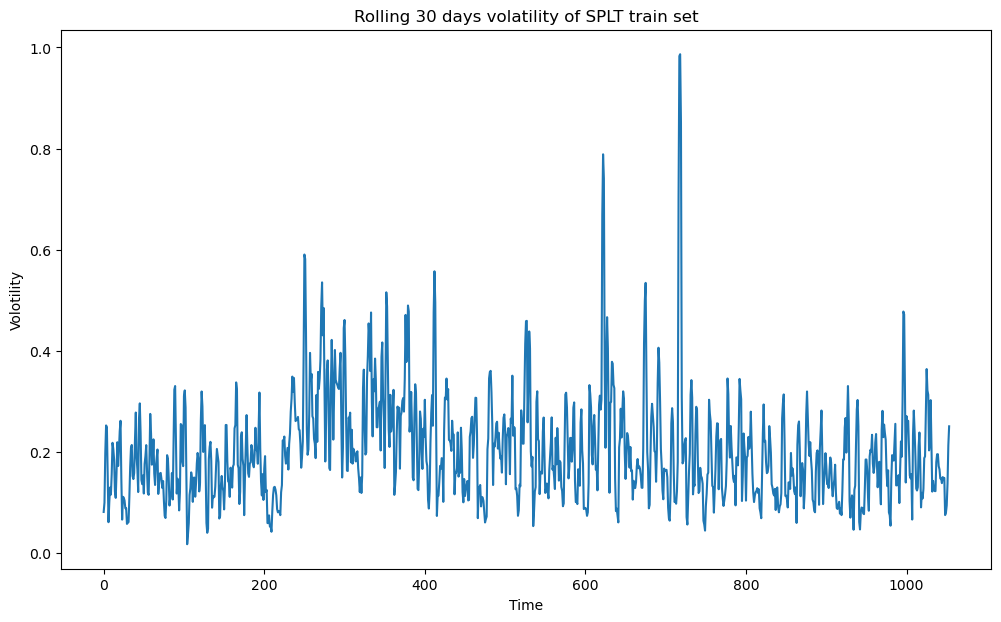

In [1580]:
# Rolling volatility
window=5
rolling_volatility = np.zeros(len(train_set) - window + 1)  

for i in range(len(train_set) - window + 1):
    window_returns = splt[i:i+window]
    rolling_volatility[i] = np.std(window_returns) 

plt.figure(figsize =(12,7))  
plt.plot(rolling_volatility)
plt.xlabel('Time')
plt.ylabel("Volotility")
plt.title('Rolling 30 days volatility of SPLT train set')


Turnover S1 and S2 1567615780.0151238
Turnover per unit traded S1 and S2 44167171.80502559


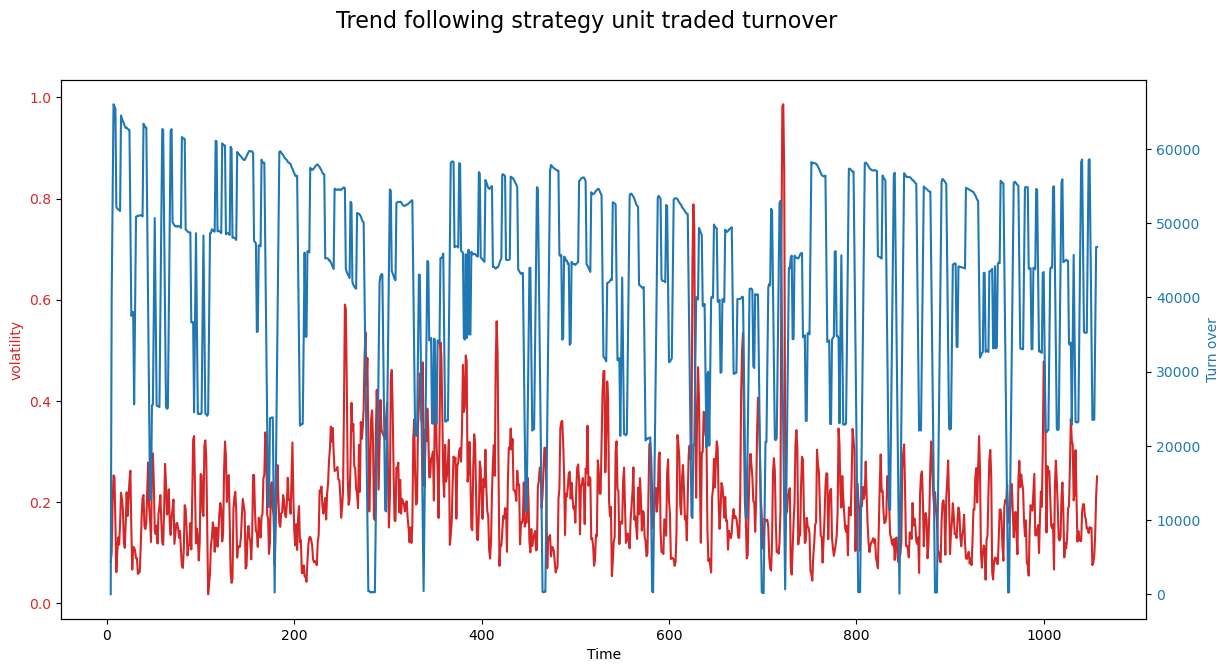

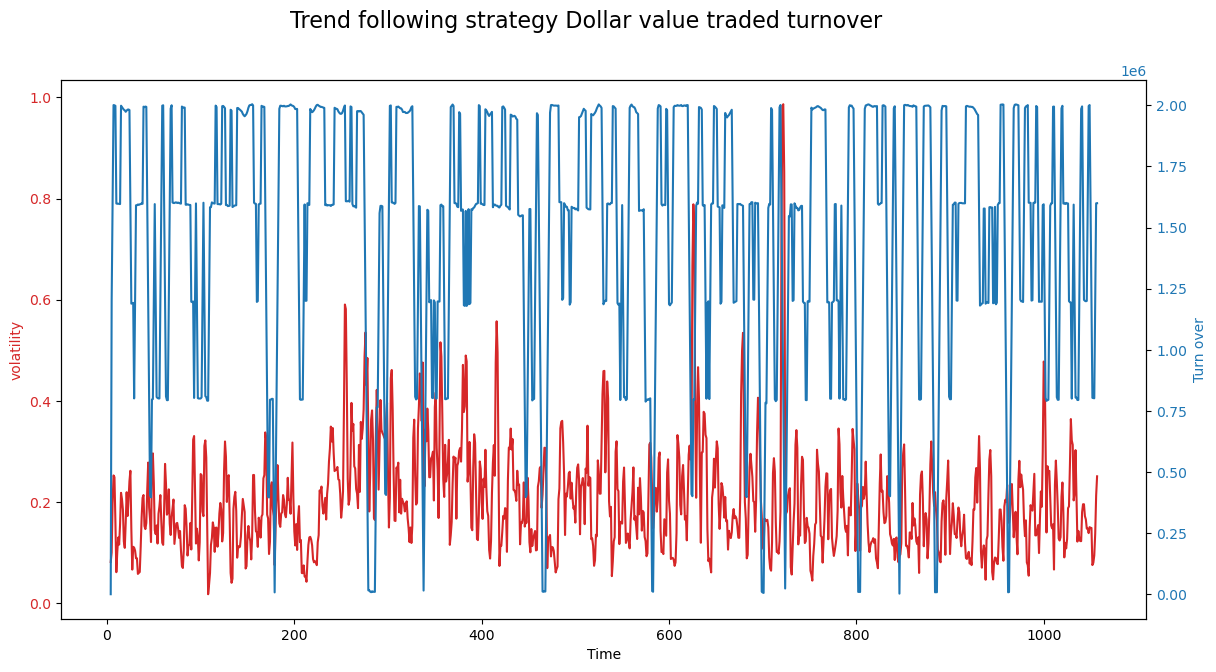

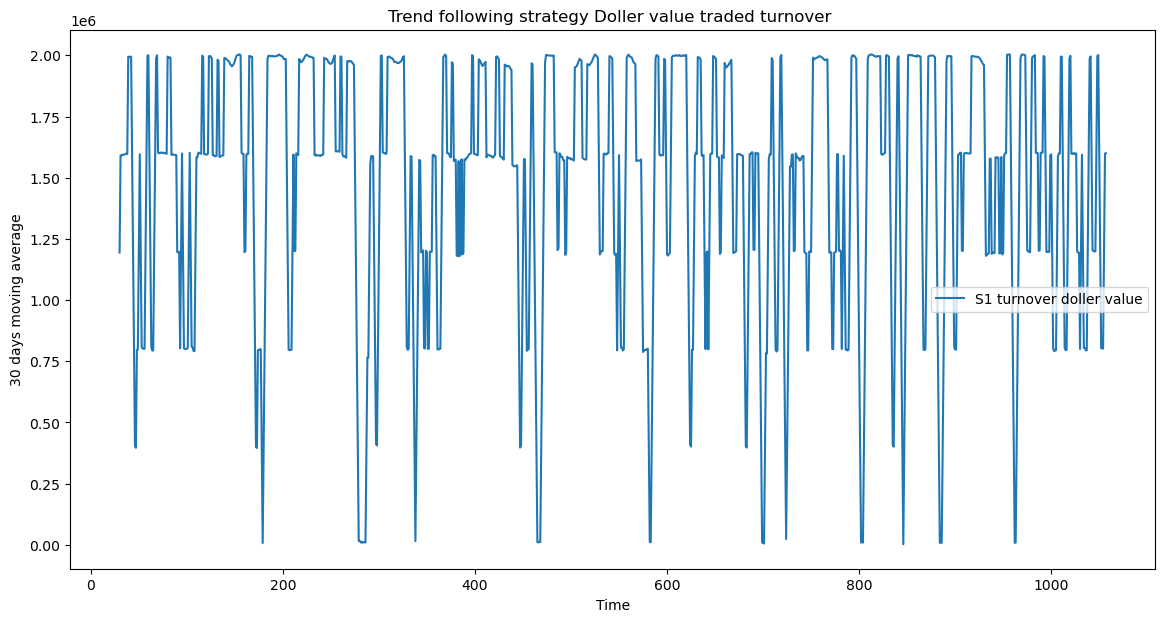

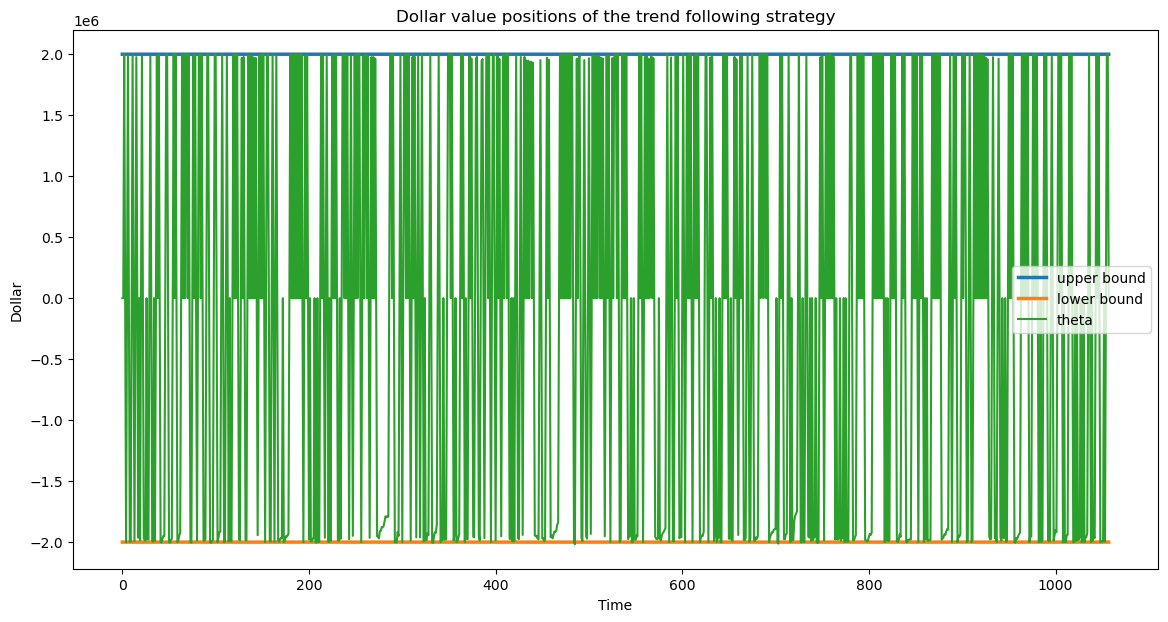

In [1582]:
# turn over S2
t=np.arange(0,len(cash2))
turnover_S2=[0]
for i in range(1,len(holding_tick_long_short)):
    theta = np.abs((holding_tick_long_short[i]*train_set[i]-holding_tick_long_short[i-1]*train_set[i]))
    turnover_S2.append(theta)

print('Turnover S1 and S2',np.sum(turnover_S2))


# turn over and unite of trade
turnPerUnit_S1=[0]
for i in range(1,len(holding_tick_long_short)):
    theta = np.abs(holding_tick_long_short[i]-holding_tick_long_short[i-1])
    turnPerUnit_S1.append(theta)

# Normalise
# min_val = min(turnPerUnit_S1)
# max_val = max(turnPerUnit_S1)
# # turnPerUnit_S1 = [(x - min_val) / (max_val - min_val) for x in turnPerUnit_S1]

print('Turnover per unit traded S1 and S2',np.sum(turnPerUnit_S1))


# moving average of turn over
window =5
S1ma1=[0]*window
S1ma2=[0]*window

i=window
for i in range (i,len(cash2)):
    s1m1=np.sum([turnover_S2[i-x] for x in range(1,window+1)])/window
    s1m2=np.sum([turnPerUnit_S1[i-x] for x in range(1,window+1)])/window 
    S1ma1.append(s1m1)
    S1ma2.append(s1m2)


# Plot unit turn over

fig, ax1 = plt.subplots(figsize =(14,7))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('volatility', color=color)
ax1.plot(t[4:], rolling_volatility, color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.suptitle('Trend following strategy unit traded turnover', fontsize=16) 
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Turn over', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], S1ma2[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)



fig, ax1 = plt.subplots(figsize =(14,7))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('volatility', color=color)
ax1.plot(t[4:], rolling_volatility, color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.suptitle('Trend following strategy Dollar value traded turnover', fontsize=16) 
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Turn over', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], S1ma1[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Plot value turn over
plt.figure(figsize =(14,7))
# plt.plot(t,S1ma2,label='S1 turnover unit traded')
plt.plot(np.arange(len(S1ma2))[30:],S1ma1[30:],label='S1 turnover doller value')
plt.title('Trend following strategy Doller value traded turnover ')
plt.xlabel('Time')
plt.ylabel("30 days moving average")
plt.legend()
plt.show()

c1=[V0*L]*len(t)
c2=[-V0*L]*len(t)
# plot theta 0
plt.figure(figsize =(14,7))
plt.plot(t,c1,linewidth=2.5,label='upper bound')
plt.plot(t,c2,linewidth=2.5,label ='lower bound')
plt.title("Dollar value positions of the trend following strategy")
plt.plot(t,holding_tick_long_short*np.array(train_set),label='theta')
plt.xlabel('Time')
plt.ylabel("Dollar")
plt.legend()
plt.show()

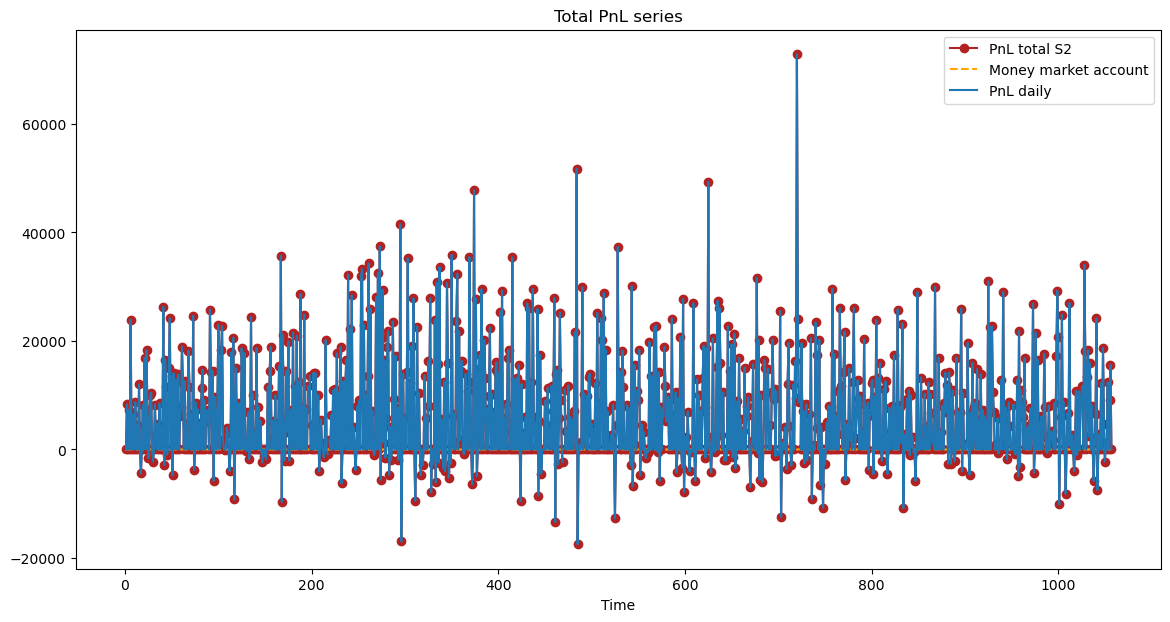

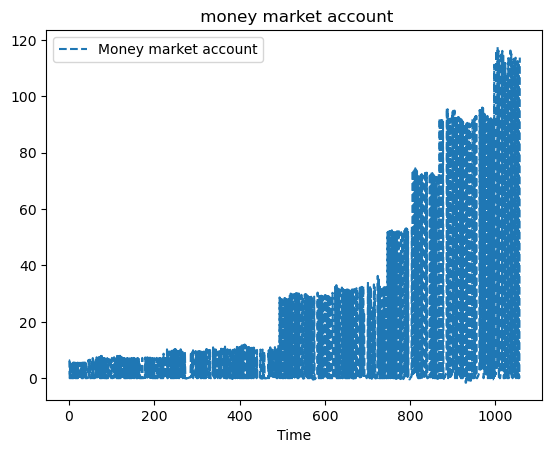

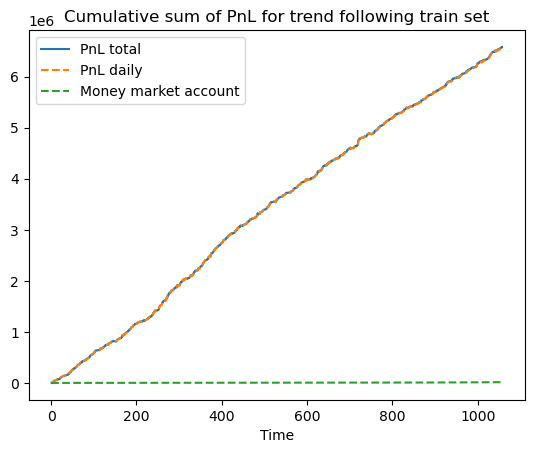

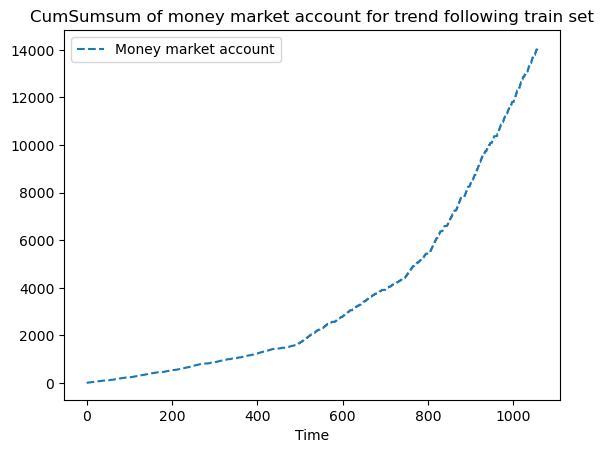

In [1583]:
# Total PnL S2

theta_S2 =holding_tick_long_short*np.array(train_set)
daily_PnL_S2 =splt_excess_return_train*theta_S2

money_capital_S2 =[0]*len(cash2)

for i in range(0,len(cash2)):
    m = (cash2[i])*(train_set_EFFR[i])
    money_capital_S2[i]=m
money_capital_S2= np.nan_to_num(money_capital_S2)
PnL_Total_S2 =daily_PnL_S2+money_capital_S2
# print(np.isnan(np.cumsum(daily_PnL_S2)[20:50]))
t=np.arange(0,len(train_set))
plt.figure(figsize =(14,7))
plt.plot(t,PnL_Total_S2,label='PnL total S2',marker='o',color='firebrick')
plt.plot(t,money_capital_S2,label='Money market account',linestyle='--',color='orange')
plt.plot(t,daily_PnL_S2,linestyle ='-',label='PnL daily')
plt.title("Total PnL series")
plt.xlabel('Time')
plt.legend()
plt.show()

# plt.plot(t,PnL_Total_S2,label='PnL total S2',marker='o',color='firebrick')
plt.plot(t,money_capital_S2,label='Money market account',linestyle='--')
# plt.plot(t,daily_PnL_S2,linestyle ='-',label='PnL daily')
plt.title(" money market account")
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(t,np.cumsum(PnL_Total_S2),label='PnL total')
plt.plot(t,np.cumsum(daily_PnL_S2),linestyle ='--',label='PnL daily')
plt.plot(t,np.cumsum(money_capital_S2),label='Money market account',linestyle='--')
plt.title("Cumulative sum of PnL for trend following train set")
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(t,np.cumsum(money_capital_S2),label='Money market account',linestyle='--')
plt.title("CumSumsum of money market account for trend following train set")
plt.xlabel('Time')
plt.legend()
plt.show()

Performance

In [1584]:
#  Trend following Test set
window = 2
cash22 =[V0*L]*len(test_set)
holding_tick_long_short_test =[0]*len(test_set)
constrain = V0*L
MA=[test_set[0]]*window
i = window
buy =False
short = False
short_price=0



while (i < len(test_set)):

    ma =np.sum([test_set[i-x] for x in range(1,window+1)])/window
    MA.append(ma)
    if not buy and not short:
        if test_set[i]> ma:
             # when price moving average excesss, buy
            if cash22[i-1]>constrain:
                holding_tick_long_short_test[i]=(constrain/test_set[i])
                cash22[i]=cash22[i-1]-constrain
            else:
                holding_tick_long_short_test [i]=(cash22[i-1]/test_set[i])
                cash22[i]=0
            buy = True
            # print('buy',i,holding_tick[i],train_set[i])
        elif test_set[i] < ma:
            if cash22[i-1]>constrain:
                holding_tick_long_short_test [i]=-(constrain/test_set[i])
                cash22[i]=cash22[i]-constrain
            
            else: 
                holding_tick_long_short_test[i]=-(cash22[i-1]/test_set[i])
                cash22[i]=0
            short_price =test_set[i]
            short =True 
        else:
            holding_tick_long_short_test[i]=(holding_tick_long_short_test [i-1])
            cash22[i]=cash22[i-1]

    elif buy:
        if test_set[i] < 1.01*ma:
            holding_tick_long_short_test [i]=0
            cash22[i]=(holding_tick_long_short_test [i-1]*test_set[i])+cash22[i-1]
            buy =False
        else:
            if holding_tick_long_short_test [i-1]*test_set[i]<=constrain:
                holding_tick_long_short_test [i]=(holding_tick_long_short_test [i-1])
                cash22[i]=cash22[i-1]
            else:
                holding_tick_long_short_test[i]=constrain/test_set[i]
                cash22[i]= test_set[i]*(holding_tick_long_short_test[i-1]-holding_tick_long_short_test[i])+cash22[i-1]
    elif short: 
        if test_set[i]>= ma:
            holding_tick_long_short_test[i]=0
            cash22[i]= np.abs(holding_tick_long_short_test [i-1])*(2*short_price-test_set[i])+cash22[i-1]
            short_price =0
            short = False
            # print('short sell',i,cash[i],train_set[i])
        else:
            if np.abs(holding_tick_long_short_test[i-1])*(2*short_price-test_set[i])+cash22[i-1] >constrain:
                holding_tick_long_short_test[i]=-constrain/(2*short_price-test_set[i])
                cash22[i]=cash22[i-1]+(np.abs(holding_tick_long_short_test[i-1])-np.abs(holding_tick_long_short_test[i]))*(2*short_price-test_set[i])
                
            else:
                holding_tick_long_short_test [i]=(holding_tick_long_short_test [i-1])
                cash22[i]=cash22[i-1]
            # print('short same sell',i,holding_tick[i],train_set[i])
    
    i+=1

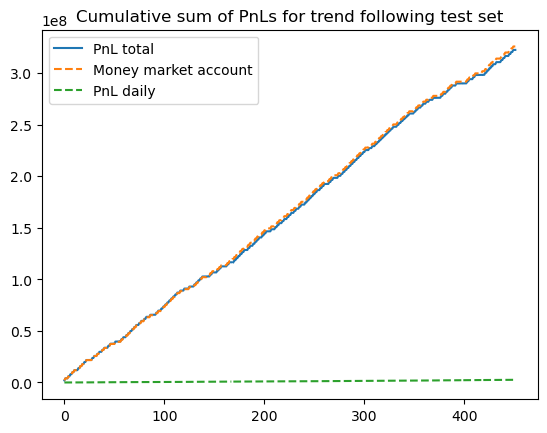

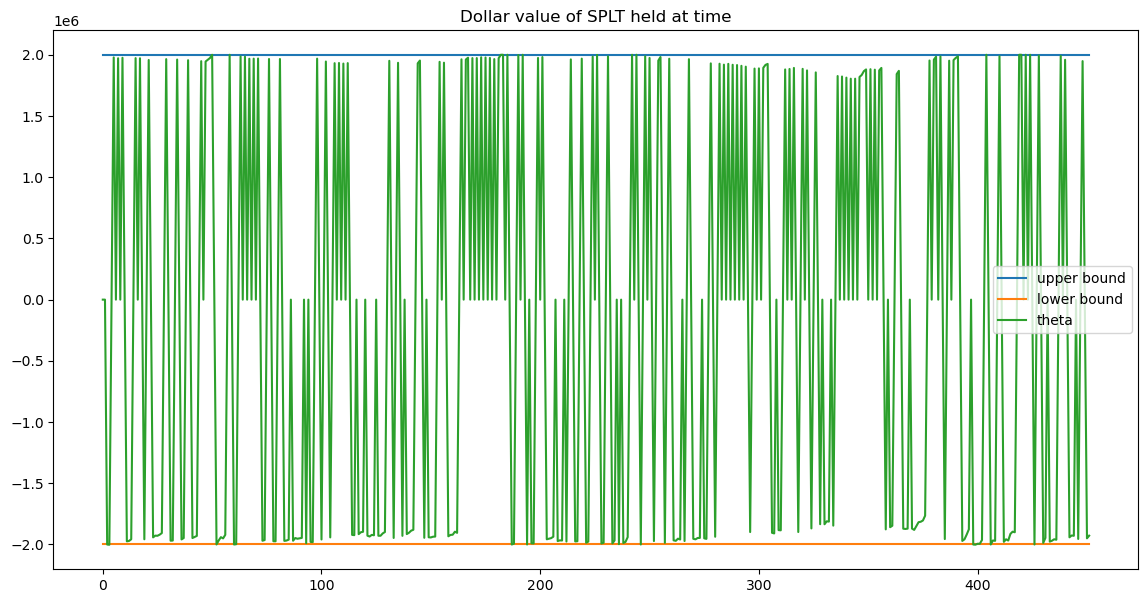

In [1585]:
# test set

theta_S2_test =holding_tick_long_short_test*np.array(test_set)
daily_PnL_S2_test =splt_excess_return_test*theta_S2_test
money_capital_S2_test =[0]*len(cash22)

for i in range(0,len(cash22)):
    m = (cash22[i])*(1+test_set_EFFR[i])
    money_capital_S2_test[i]=m
money_capital_S2_test= np.nan_to_num(money_capital_S2_test)
PnL_Total_S2_test =daily_PnL_S2_test+money_capital_S2_test

t=np.arange(0,len(test_set))

plt.plot(t,np.cumsum(PnL_Total_S2_test),label='PnL total')
plt.plot(t,np.cumsum(money_capital_S2_test),label='Money market account',linestyle='--')
plt.plot(t,np.cumsum(daily_PnL_S2_test),linestyle ='--',label='PnL daily')
plt.title("Cumulative sum of PnLs for trend following test set")
plt.legend()
plt.show()

c1=[V0*L]*len(t)
c2=[-V0*L]*len(t)
# plot theta 0
plt.figure(figsize =(14,7))
plt.plot(t,c1,label='upper bound')
plt.plot(t,c2,label ='lower bound')
plt.title("Dollar value of SPLT held at time")
plt.plot(t,theta_S2_test,label='theta')
plt.legend()
plt.show()

In [1586]:
# Sharpe Ratio (SR), Sortino Ratio, Maximum Drawdown and the Calmar ratio
std_trainset = np.std(daily_PnL_S2)
std_testset = np.std(daily_PnL_S2_test)
SR = daily_PnL_S2/std_trainset
SR_test=daily_PnL_S2_test/std_testset

downside_returns = np.minimum(daily_PnL_S2, 0)
SortinoRatio=daily_PnL_S2/np.std(downside_returns)

# https://quant.stackexchange.com/questions/18094/how-can-i-calculate-the-maximum-drawdown-mdd-in-python
window =len('train_set')
data ={'data':daily_PnL_S2}
df=pd.DataFrame(data)
Roll_Max = df['data'].rolling(window, min_periods=1).max()
Roll_min = df['data'].rolling(window, min_periods=1).min()
max_drawdown =(np.max(Roll_Max)-np.min(Roll_min))

# maximum draw down\

calmar_ratio = max_drawdown/np.max(Roll_Max)


downside_returnst = np.minimum(daily_PnL_S2_test, 0)
SortinoRatiot=daily_PnL_S2/np.std(downside_returnst)

window =len('test_set')
data ={'data':daily_PnL_S2_test}
df=pd.DataFrame(data)
Roll_Max2 = df['data'].rolling(window, min_periods=1).max()
Roll_min = df['data'].rolling(window, min_periods=1).min()
max_drawdownt =(np.max(Roll_Max2)-np.min(Roll_min))

# maximum draw down\
calmar_ratiot = max_drawdownt/np.max(Roll_Max2)


print('SR train',np.mean(SR),np.mean(SortinoRatio),max_drawdown,np.mean(calmar_ratio))
print('SR test:',np.mean(SR_test),np.mean(SortinoRatiot),max_drawdownt,np.mean(calmar_ratiot))

SR train 0.637847771304296 3.583214310968544 90320.60955484702 1.2396946039691052
SR test: 0.6438709699013543 4.428042461118541 54510.72924714662 1.308645329116777


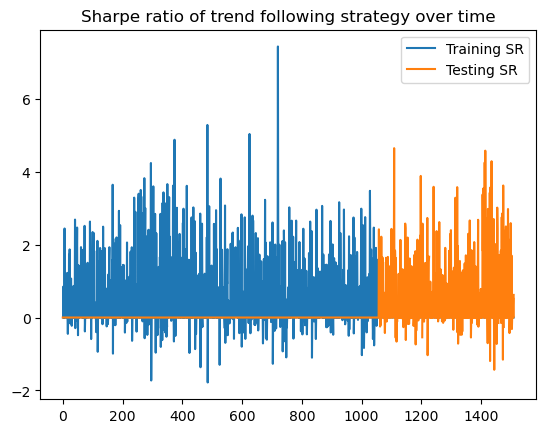

In [1587]:
# rolling Sharp ratio 


s1=[0]*len(splt)
s2=[0]*len(splt)
for i in range(len(splt)):
    if i<len(train_set):
        s2[i]=0
        s1[i]=SR[i]
    else:
        s1[i]=0
        s2[i]=SR_test[i-len(train_set)-1]

t=np.arange(0,len(splt))
plt.plot(t,s1,label='Training SR')
plt.plot(t,s2,label='Testing SR')
plt.title('Sharpe ratio of trend following strategy over time')
plt.legend()
plt.show()



Text(0.5, 1.0, 'Rolling 30 days volatility of SPLT train set')

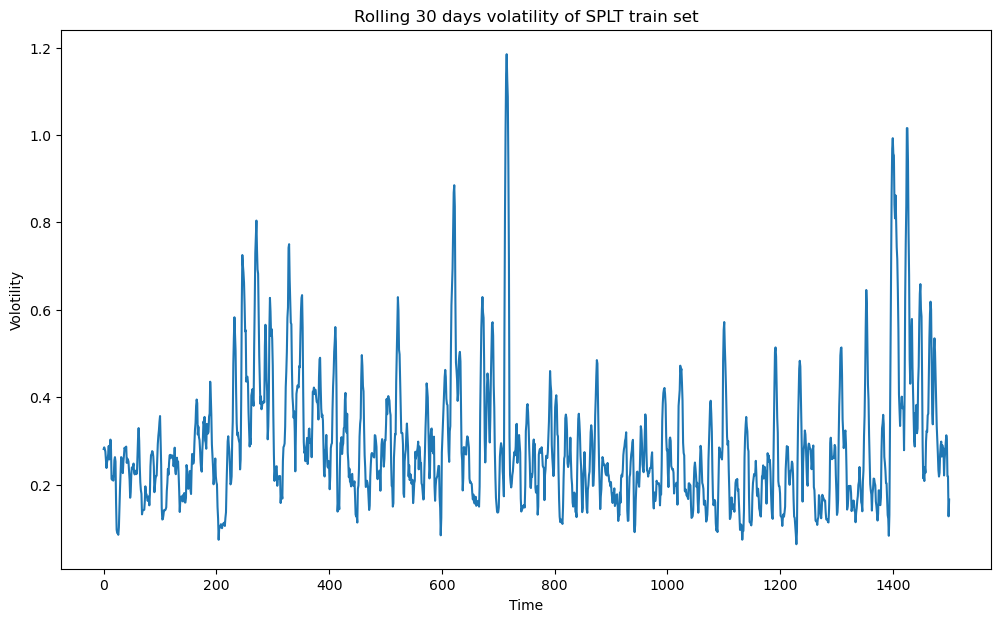

In [1627]:
# Rolling volatility
window=10
rolling_volatility = np.zeros(len(splt) - window + 1)  

for i in range(len(splt) - window + 1):
    window_returns = splt[i:i+window]
    rolling_volatility[i] = np.std(window_returns) 

plt.figure(figsize =(12,7))  
plt.plot(rolling_volatility)
plt.xlabel('Time')
plt.ylabel("Volotility")
plt.title('Rolling 30 days volatility of SPLT train set')

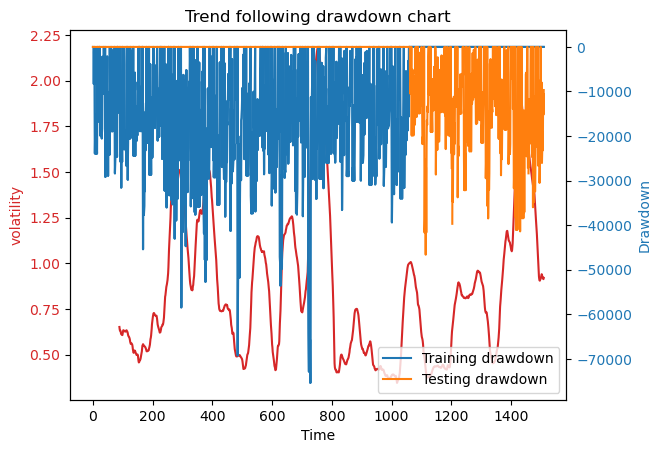

In [1590]:
# drawdown chart Trend train set

daily_PnL_S2=np.nan_to_num(daily_PnL_S2)

dd1=[0]*len(splt)
dd2=[0]*len(splt)
for i in range(len(splt)):
    if i<len(train_set):
        dd2[i]=0
        dd1[i]=daily_PnL_S2[i]-Roll_Max[i]
    else:
        dd1[i]=0
        dd2[i]=(daily_PnL_S2_test[i-len(train_set)-1] -Roll_Max2[i-len(train_set)-1])

roll_vo=splt.rolling(window=90).std()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('volatility', color=color)
ax1.plot(np.arange(len(splt))[89:], rolling_volatility, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Drawdown', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], dd1[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)
t=np.arange(0,len(splt))

plt.plot(t,dd1,label='Training drawdown')
plt.plot(t,dd2,label='Testing drawdown')
plt.xlabel('Time')
plt.title('Trend following drawdown chart')
plt.legend()
plt.show()


mean reverting of return in short period of time

In [1614]:
#  Mean reverting
window = 2
cash3 =[V0*L]*len(train_set)
holdings_train_MV=[0]*len(train_set)
constrain = V0*L
MA=[train_set[0]]*window
rema=[train_set[0]]*window
i = window
buy =False
short = False
short_price=0
short_asset=0
while (i < len(train_set)):
    a =(train_set[i]-train_set[i-1])/train_set[i-1]
    MA.append(a)
    r =np.sum([MA[i-x] for x in range(1,window+1)])/window
    rema.append(r)
    if not buy and not short:
        if r< -0.0125:
             # return is small ,long
            if cash3[i-1]>constrain:
                holdings_train_MV [i]=(constrain/train_set[i])
                cash3[i]=cash3[i-1]-constrain
            else:
                holdings_train_MV [i]=(cash3[i-1]/train_set[i])
                cash3[i]=0
            buy = True
          
        elif r >0.0125:
            # when return is large buy
            if cash3[i-1]>constrain:
                holdings_train_MV [i]=-(constrain/train_set[i])
                cash3[i]=cash3[i]-constrain
                short_asset=constrain
                
            else: 
                holdings_train_MV [i]=-(cash3[i-1]/train_set[i])
                cash3[i]=0
                short_asset=cash3[i-1]
                
            short_price =train_set[i]
            short =True 
            
        
        else:
            holdings_train_MV[i]=(holdings_train_MV [i-1])
            cash3[i]=cash3[i-1]

    elif buy:
        if r > 0.002:
            holdings_train_MV[i]=0
            cash3[i]=(holdings_train_MV[i-1]*train_set[i])+cash3[i-1]
            buy =False
        else:
            if holdings_train_MV[i-1]*train_set[i]<=constrain:
                holdings_train_MV[i]=(holdings_train_MV [i-1])
                cash3[i]=cash3[i-1]
            else:
                holdings_train_MV [i]=constrain/train_set[i]
                cash3[i]= train_set[i]*(holdings_train_MV [i-1]-holdings_train_MV [i])+cash3[i-1]
    elif short: 
        if r<= 0:
            holdings_train_MV [i]=0
            cash3[i]= np.abs(holdings_train_MV[i-1])*(short_price-train_set[i])+cash3[i-1]+short_asset
            short_price =0
            short = False
            # print('short sell',i,cash[i],train_set[i])
        else:
            if holdings_train_MV [i-1]*train_set[i] <constrain:
                holdings_train_MV[i]=-constrain/(train_set[i])
                cash3[i]=cash3[i-1]+np.abs(holdings_train_MV[i-1]-holdings_train_MV[i])*(2*short_price-train_set[i])
            else:
                holdings_train_MV [i]=holdings_train_MV [i-1]
                cash3[i]=cash3[i-1]
            # print('short same sell',i,holding_tick[i],train_set[i])
    i+=1

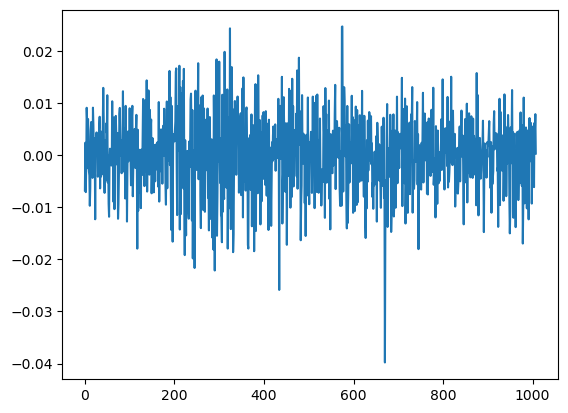

In [1406]:
plt.plot(MA[50:])

0.023513732466308668


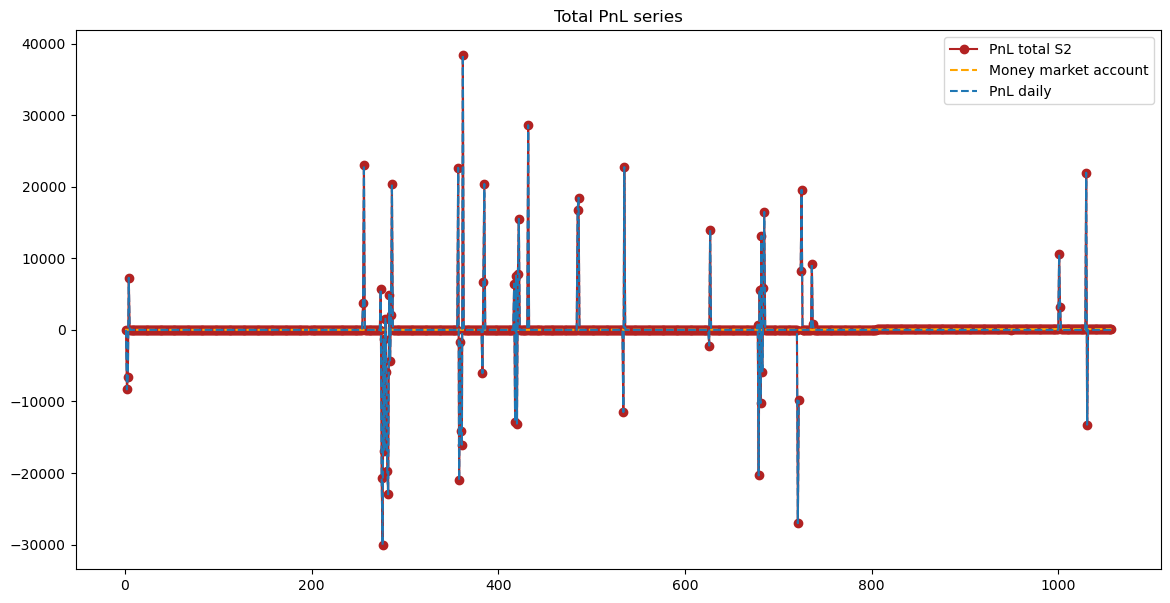

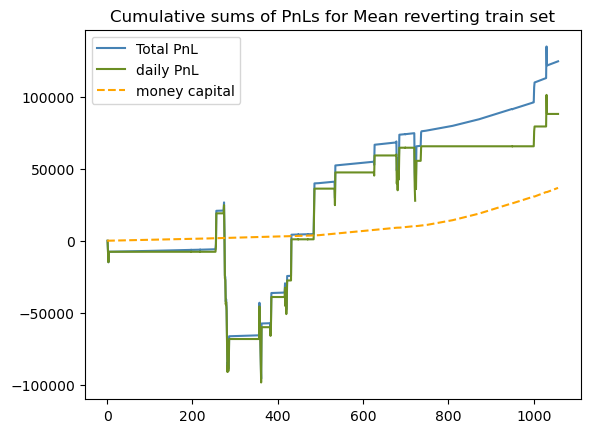

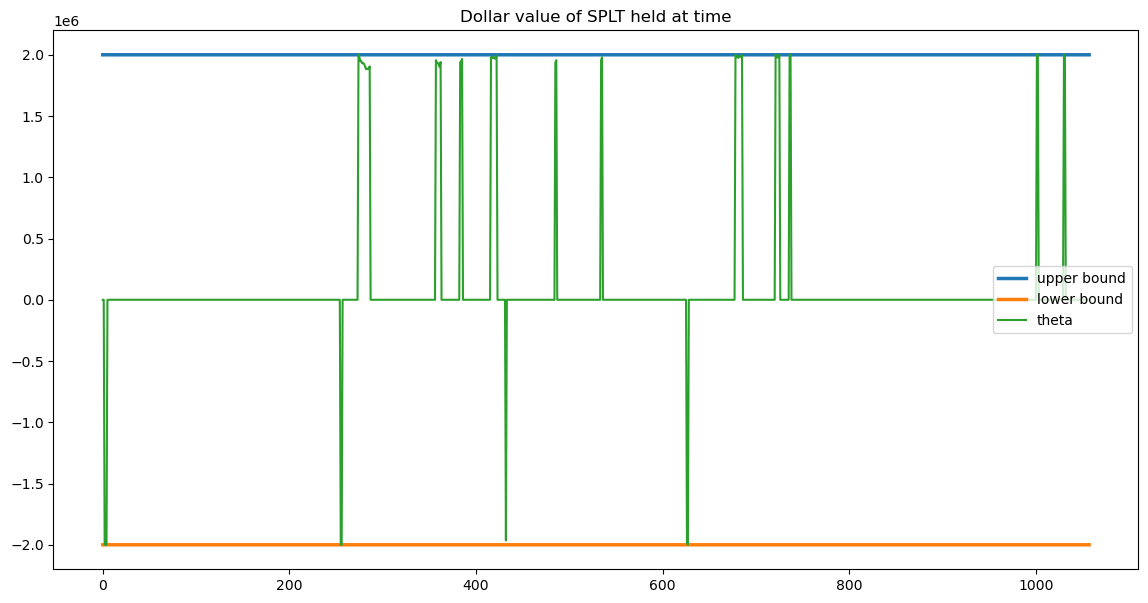

In [1615]:
theta_S3 =holdings_train_MV*np.array(train_set)
daily_PnL_S3 =splt_excess_return_train*theta_S3

money_capital_S3 =[0]*len(cash3)

for i in range(0,len(cash3)):
    m = (cash3[i])*(train_set_EFFR[i])
    money_capital_S3[i]=m
    
money_capital_S3= np.nan_to_num(money_capital_S3)
PnL_Total_S3 =daily_PnL_S3+money_capital_S3

SR = np.mean(daily_PnL_S3)/np.std(daily_PnL_S3)
print(SR)
plt.figure(figsize =(14,7))

t=np.arange(0,len(train_set))
plt.plot(t,PnL_Total_S3,label='PnL total S2',marker='o',color ='firebrick')
plt.plot(t,money_capital_S3,label='Money market account',linestyle='--',color='orange')
plt.plot(t,daily_PnL_S3,linestyle ='--',label='PnL daily')
plt.title("Total PnL series")
plt.legend()
plt.show()

plt.plot(t,np.cumsum(PnL_Total_S3),label='Total PnL',color ='steelblue')
plt.plot(t,np.cumsum(daily_PnL_S3),label='daily PnL',color='olivedrab')
plt.plot(t,np.cumsum(money_capital_S3),label ='money capital',linestyle='--', color='orange')
plt.title('Cumulative sums of PnLs for Mean reverting train set')
plt.legend()
plt.show()
c1=[V0*L]*len(t)
c2=[-V0*L]*len(t)
# plot theta 0
plt.figure(figsize =(14,7))
plt.plot(t,c1,linewidth=2.5,label='upper bound')
plt.plot(t,c2,linewidth=2.5,label ='lower bound')
plt.title("Dollar value of SPLT held at time")
plt.plot(t,theta_S3,label='theta')
plt.legend()
plt.show()

Turnover S1 and S2 59530336.83795474
Turnover per unit traded S1 and S2 1670859.3155503226


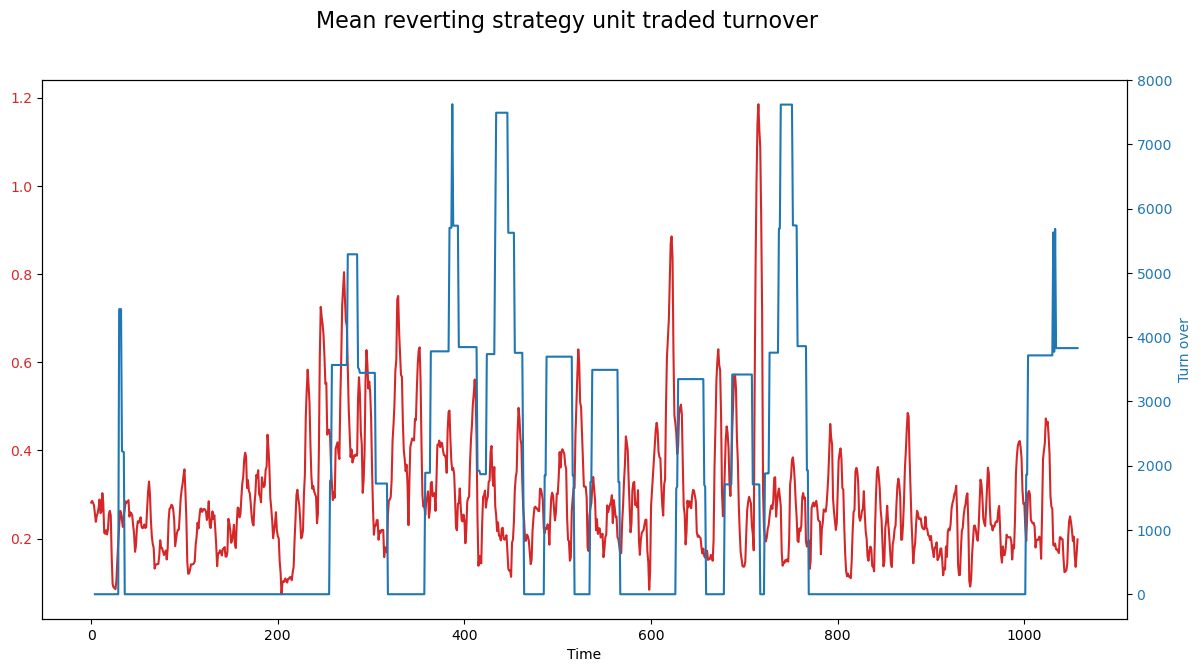

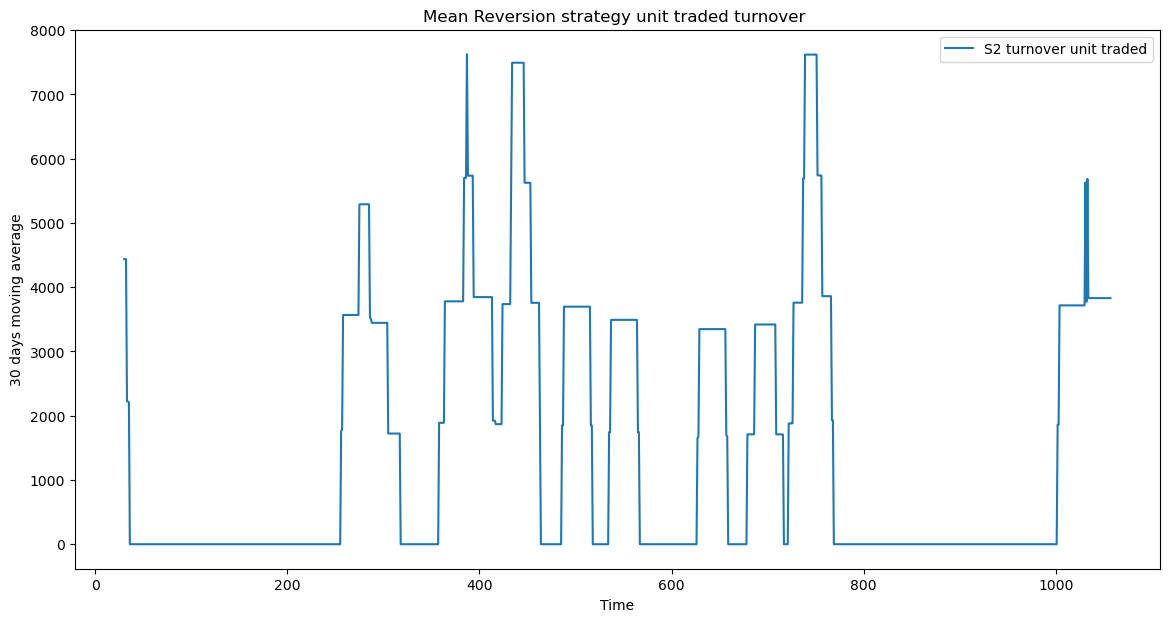

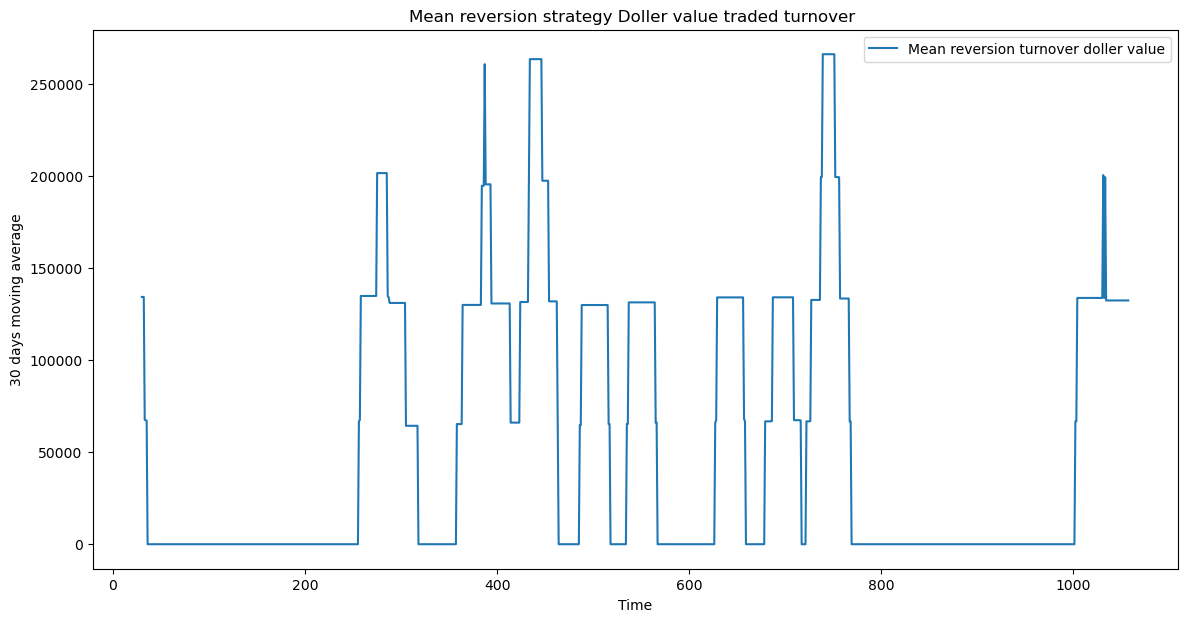

In [1628]:
# turn over Mean reverting
t=np.arange(0,len(cash2))
turnover_S3=[0]
for i in range(1,len(holdings_train_MV)):
    theta = np.abs((holdings_train_MV[i]*train_set[i]-holdings_train_MV[i-1]*train_set[i]))
    turnover_S3.append(theta)

print('Turnover S1 and S2',np.sum(turnover_S3))


# turn over and unite of trade
turnPerUnit_S3=[0]
for i in range(1,len(holdings_train_MV)):
    theta = np.abs(holdings_train_MV[i]-holdings_train_MV[i-1])
    turnPerUnit_S3.append(theta)

# Normalise
# min_val = min(turnPerUnit_S1)
# max_val = max(turnPerUnit_S1)
# # turnPerUnit_S1 = [(x - min_val) / (max_val - min_val) for x in turnPerUnit_S1]

print('Turnover per unit traded S1 and S2',np.sum(turnPerUnit_S3))


# moving average of turn over
window =30
S1ma1=[0]*window
S1ma2=[0]*window

i=window
for i in range (i,len(cash3)):
    s1m1=np.sum([turnover_S3[i-x] for x in range(1,window+1)])/window
    s1m2=np.sum([turnPerUnit_S3[i-x] for x in range(1,window+1)])/window 
    S1ma1.append(s1m1)
    S1ma2.append(s1m2)

fig, ax1 = plt.subplots(figsize =(14,7))

color = 'tab:red'

t=np.arange(len(train_set))


ax1.set_xlabel('Time')
ax1.set_ylabel('', color=color)
ax1.plot(t[:len(train_set)], rolling_volatility[:len(train_set)], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.suptitle('Mean reverting strategy unit traded turnover', fontsize=16) 
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Turn over', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], S1ma2[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Plot unit turn over
plt.figure(figsize =(14,7))
plt.plot(np.arange(len(S1ma2))[30:],S1ma2[30:],label='S2 turnover unit traded')

plt.title('Mean Reversion strategy unit traded turnover ')
plt.xlabel('Time')
plt.ylabel("30 days moving average")
plt.legend()
plt.show()

# Plot value turn over
plt.figure(figsize =(14,7))
# plt.plot(t,S1ma2,label='S1 turnover unit traded')
plt.plot(np.arange(len(S1ma2))[30:],S1ma1[30:],label='Mean reversion turnover doller value')
plt.title('Mean reversion strategy Doller value traded turnover ')
plt.xlabel('Time')
plt.ylabel("30 days moving average")
plt.legend()
plt.show()

# plot theta 0

In [1604]:
#   Mean reverting Test set
window = 2
cash4 =[V0*L]*len(test_set)
holdings_test_MV=[0]*len(test_set)
constrain = V0*L
MA=[test_set[0]]*window
rema=[test_set[0]]*window
i = window
buy =False
short = False
short_price=0

while (i < len(test_set)):
    a =(test_set[i]-test_set[i-1])/test_set[i-1]
    MA.append(a)
    r =np.sum([MA[i-x] for x in range(1,window+1)])/window
    rema.append(r)
    if not buy and not short:
        if r< -0.0125:
             # return is small ,long
            if cash4[i-1]>constrain:
                holdings_test_MV [i]=(constrain/test_set[i])
                cash4[i]=cash4[i-1]-constrain
            else:
                holdings_test_MV [i]=(cash4[i-1]/test_set[i])
                cash4[i]=0
            buy = True
            
        elif r >0.0125:
            # when return is large buy
            if cash4[i-1]>constrain:
                holdings_test_MV [i]=-(constrain/test_set[i])
                cash4[i]=cash4[i]-constrain
     
            else: 
                holdings_test_MV [i]=-(cash4[i-1]/test_set[i])
                cash4[i]=0
           
            short_price =test_set[i]
            short =True 
        else:
            holdings_test_MV[i]=(holdings_test_MV [i-1])
            cash4[i]=cash4[i-1]

    elif buy:
        if r >0.002:
            holdings_test_MV[i]=0
            cash4[i]=(holdings_test_MV[i-1]*test_set[i])+cash4[i-1]
            buy =False
        else:
            if holdings_test_MV[i-1]*test_set[i]<=constrain:
                holdings_test_MV[i]=(holdings_test_MV [i-1])
                cash4[i]=cash4[i-1]
            else:
                holdings_test_MV [i]=constrain/test_set[i]
                cash4[i]= test_set[i]*(holdings_test_MV [i-1]-holdings_test_MV [i])+cash4[i-1]
    elif short: 
        if r< 0:
            holdings_test_MV [i]=0
            cash4[i]= np.abs(holdings_test_MV[i-1])*(2*short_price-test_set[i])+cash4[i-1]
            short_price =0
            short = False
            # print('short sell',i,cash[i],train_set[i])
        else:
            if np.abs(holdings_test_MV [i-1])*test_set[i]>constrain:
                holdings_test_MV[i]=-(constrain)/test_set[i]
                cash4[i]=cash4[i-1]+np.abs(holdings_test_MV[i-1]-holdings_test_MV[i])*(2*short_price-test_set[i])
            else:
                holdings_test_MV [i]=(holdings_test_MV [i-1])
                cash4[i]=cash4[i-1]
            # print('short same sell',i,holding_tick[i],train_set[i])
    i+=1

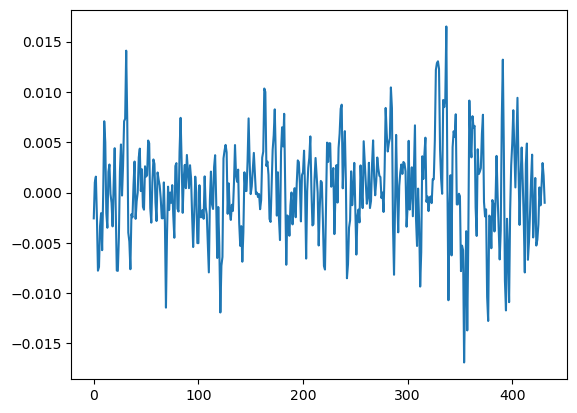

In [1436]:
plt.plot(rema[20:])

0.020413662592697432


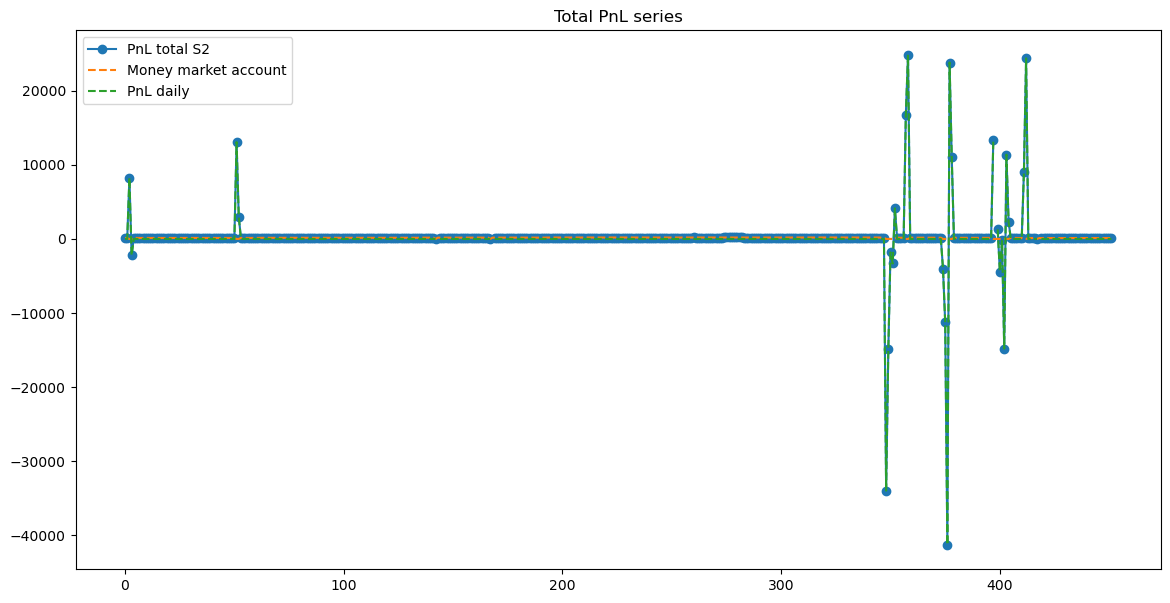

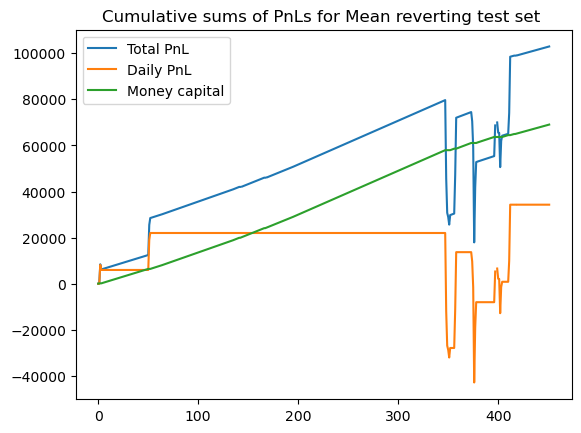

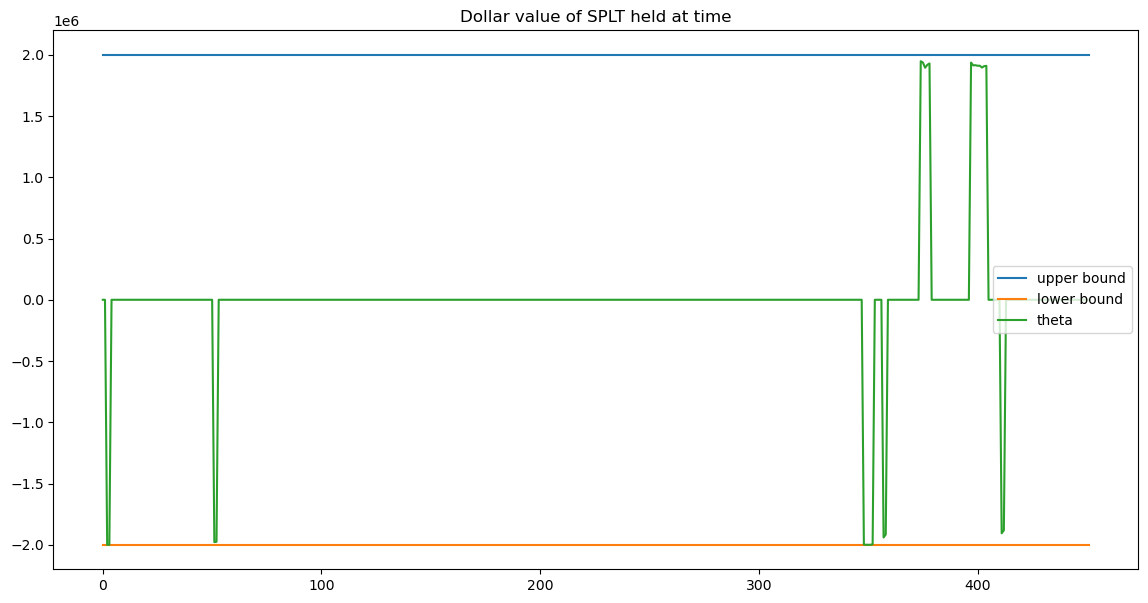

In [1605]:
theta_S3_test =holdings_test_MV*np.array(test_set)
daily_PnL_S3_test =splt_excess_return_test*theta_S3_test

money_capital_S3_test =[0]*len(cash4)

for i in range(0,len(cash4)):
    m = (cash4[i])*(test_set_EFFR[i])
    money_capital_S3_test[i]=m

money_capital_S3_test= np.nan_to_num(money_capital_S3_test)

PnL_Total_S3_test =daily_PnL_S3_test+money_capital_S3_test

SR = np.mean(daily_PnL_S3_test)/np.std(daily_PnL_S3_test)
# daily or total
print(SR)

plt.figure(figsize =(14,7))
# plt.plot(theta_S3_test)
# plt.show()
t=np.arange(0,len(test_set))
plt.plot(t,PnL_Total_S3_test,label='PnL total S2',marker='o')
plt.plot(t,money_capital_S3_test,label='Money market account',linestyle='--')
plt.plot(t,daily_PnL_S3_test,linestyle ='--',label='PnL daily')
plt.title("Total PnL series")
plt.legend()
plt.show()
# plt.figure(figsize =(5,7))
plt.plot(t,np.cumsum(PnL_Total_S3_test),label='Total PnL')
plt.plot(t,np.cumsum(daily_PnL_S3_test),label='Daily PnL')
plt.plot(t,np.cumsum(money_capital_S3_test),label='Money capital')
plt.title("Cumulative sums of PnLs for Mean reverting test set ")
plt.legend()
plt.show()


c1=[V0*L]*len(t)
c2=[-V0*L]*len(t)
# plot theta 0
plt.figure(figsize =(14,7))
plt.plot(t,c1,label='upper bound')
plt.plot(t,c2,label ='lower bound')
plt.title("Dollar value of SPLT held at time")
plt.plot(t,theta_S3_test,label='theta')
plt.legend()
plt.show()


In [1607]:
# performance

downside_returns = np.minimum(daily_PnL_S3, 0)
SortinoRatio=daily_PnL_S3/np.std(downside_returns)

downside_returns2 = np.minimum(daily_PnL_S3_test, 0)
SortinoRatio2=daily_PnL_S3_test/np.std(downside_returns2)


window =len('train_set')
data ={'data':daily_PnL_S3}
df=pd.DataFrame(data)
Roll_Max = df['data'].rolling(window, min_periods=1).max()
Roll_min = df['data'].rolling(window, min_periods=1).min()
max_drawdown =(np.max(Roll_Max)-np.min(Roll_min))

# maximum draw down\
calmar_ratio = max_drawdown/np.max(Roll_Max)

window =len('test_set')
data ={'data':daily_PnL_S3_test}
df=pd.DataFrame(data)
Roll_Maxt = df['data'].rolling(window, min_periods=1).max()
Roll_mint = df['data'].rolling(window, min_periods=1).min()
max_drawdownt =(np.max(Roll_Maxt)-np.min(Roll_mint))

# maximum draw down\
calmar_ratiot = max_drawdownt/np.max(Roll_Max)


print(np.mean(SortinoRatio),np.mean(SortinoRatio2),np.mean(calmar_ratio),np.mean(calmar_ratiot),max_drawdown ,max_drawdownt)


# # rolling Sharp ratio 
# t=np.arange(0,len(train_set))
# plt.plot(t,SR)
# plt.title('Sharpe ratio of trend following strategy training set over time')
# plt.show()

# t=np.arange(0,len(test_set))
# plt.plot(t,SR_test)
# plt.title('Sharpe ratio of trend following strategy test set over time')
# plt.show()




0.036464687442196365 0.027657536718635894 1.7811075729418875 1.7196275950678146 68475.81123712238 66112.17446204882


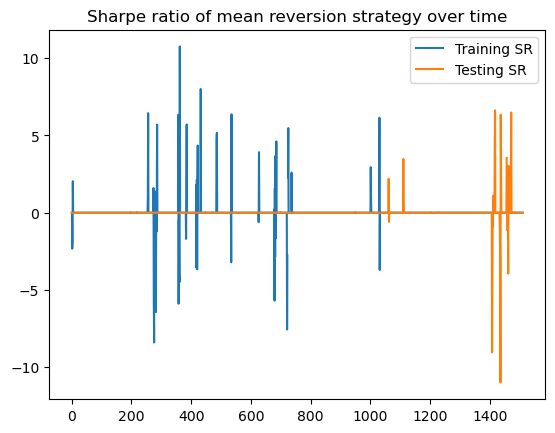

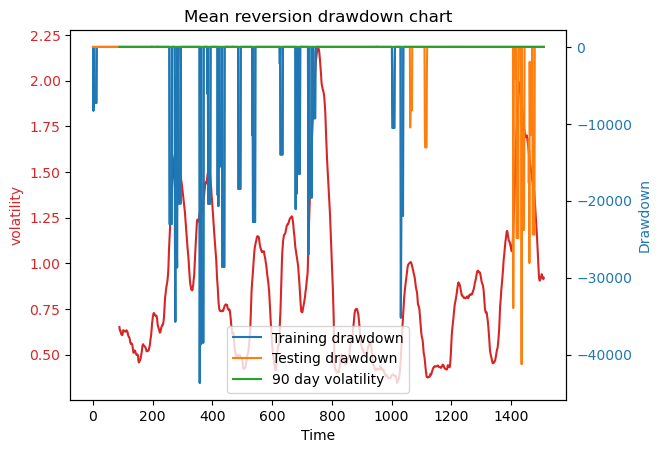

In [1608]:

SR = daily_PnL_S3/np.std(daily_PnL_S3)
SR_test= daily_PnL_S3_test/np.std(daily_PnL_S3_test)
s1=[0]*len(splt)
s2=[0]*len(splt)
for i in range(len(splt)):
    if i<len(train_set):
        s2[i]=0
        s1[i]=SR[i]
    else:
        s1[i]=0
        s2[i]=SR_test[i-len(train_set)-1]

t=np.arange(0,len(splt))
plt.plot(t,s1,label='Training SR')
plt.plot(t,s2,label='Testing SR')
plt.title('Sharpe ratio of mean reversion strategy over time')
plt.legend()
plt.show()



dd1=[0]*len(splt)
dd2=[0]*len(splt)
for i in range(len(splt)):
    if i<len(train_set):
        dd2[i]=0
        dd1[i]=daily_PnL_S3[i]-Roll_Max[i]
    else:
        dd1[i]=0
        dd2[i]=(daily_PnL_S3_test[i-len(train_set)-1] -Roll_Maxt[i-len(train_set)-1])

roll_vo=splt.rolling(window=90).std()
t=np.arange(0,len(splt))


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('volatility', color=color)
ax1.plot(np.arange(len(splt))[89:], rolling_volatility, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Drawdown', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], dd1[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)
t=np.arange(0,len(splt))

plt.plot(t,dd1,label='Training drawdown')
plt.plot(t,dd2,label='Testing drawdown')
plt.plot(t,roll_vo,label='90 day volatility')
plt.xlabel('Time')
plt.title('Mean reversion drawdown chart')
plt.legend()
plt.show()

Predictive model / AR or Ml/ARIMAX

In [115]:
from pandas.plotting import lag_plot

from pandas.plotting import autocorrelation_plot

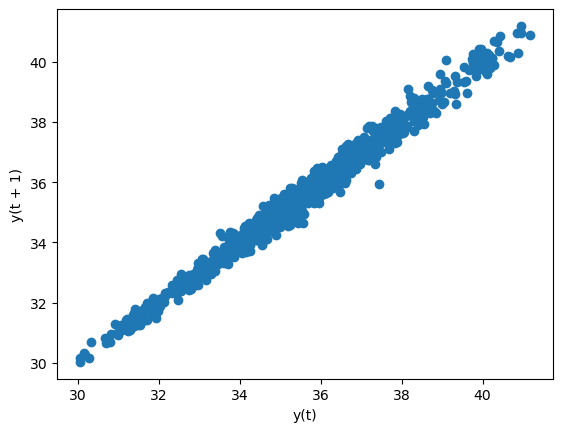

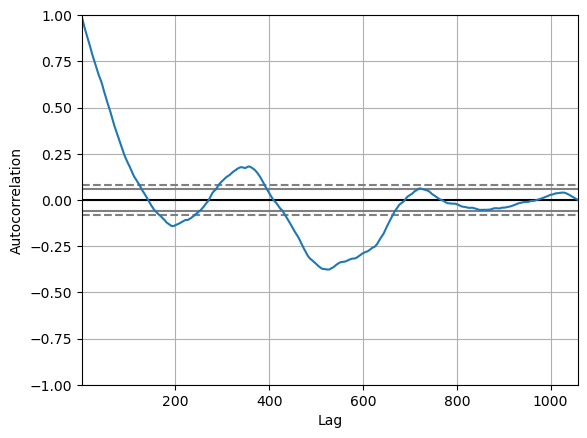

In [116]:

lag_plot(train_set)
plt.show()

autocorrelation_plot(train_set)
plt.show()

In [158]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [1561]:
# AR Train Set
time_window = 30

S=train_set.copy()
ar_prediction = train_set.copy()

holding_AR = np.zeros(np.shape(S))
cash_AR = [V0*L]*len(S)
buy = False
short = False
short_Price=0
constrain=V0*L

for i, x in enumerate(S[:-1], 0):
    if i>=time_window:
        X = S[:i]
        train = X
        # train autoregression
        model = AutoReg(train,1)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
        ar_prediction[i] = predictions.iloc[0]

    if buy == False and short == False:
        if ar_prediction[i] > 1.01*x: 
            if cash_AR[i]>constrain:
                holding_AR[i+1] = constrain/x 
                cash_AR[i+1] = cash_AR[i]-constrain
            else:
                holding_AR[i+1] = cash_AR[i]/x 
                cash_AR[i+1] = 0
            buy = True
        elif ar_prediction[i] < 0.99*x:
            if cash_AR[i]<=constrain:
                holding_AR[i+1] = -(cash_AR[i]/x ) 
                cash_AR[i+1] = 0
            else:
                holding_AR[i+1] = -(constrain/x )
                cash_AR[i+1] = cash_AR[i]-constrain
             
            short_Price=x
            short = True
        else:
            holding_AR[i+1] = holding_AR[i]
            cash_AR[i+1] = cash_AR[i]
    elif buy:   
        if ar_prediction[i] < x:
            cash_AR[i+1] = holding_AR[i]*x + cash_AR[i]
            holding_AR[i+1] = 0
            buy = False
        else:
            if holding_AR[i]*x> constrain:
                holding_AR[i]=constrain/x
                cash_AR[i]=x*(holding_AR[i]-holding_AR[i-1])+cash_AR[i-1]
            holding_AR[i+1] = holding_AR[i]
            cash_AR[i+1] = cash_AR[i]
    elif short:
        if ar_prediction[i] >= x:
            cash_AR[i+1] = np.abs(holding_AR[i])*(2*short_Price-x) + cash_AR[i]
            holding_AR[i+1] = 0
            short_Price=0
            short = False
        else:
            if np.abs(holding_AR[i])*x> constrain:
                holding_AR[i]=-(constrain/x)
                cash_AR[i] = np.abs(holding_AR[i-1]-holding_AR[i])*(2*short_price-x)+cash_AR[i-1]
            holding_AR[i+1] = holding_AR[i]
            cash_AR[i+1] = cash_AR[i]

# ar_strategy = [a*b for a,b in zip(holding_AR,S)]+ cash_AR



/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, Datetime

0.08687583706132215 0.14074794715690686


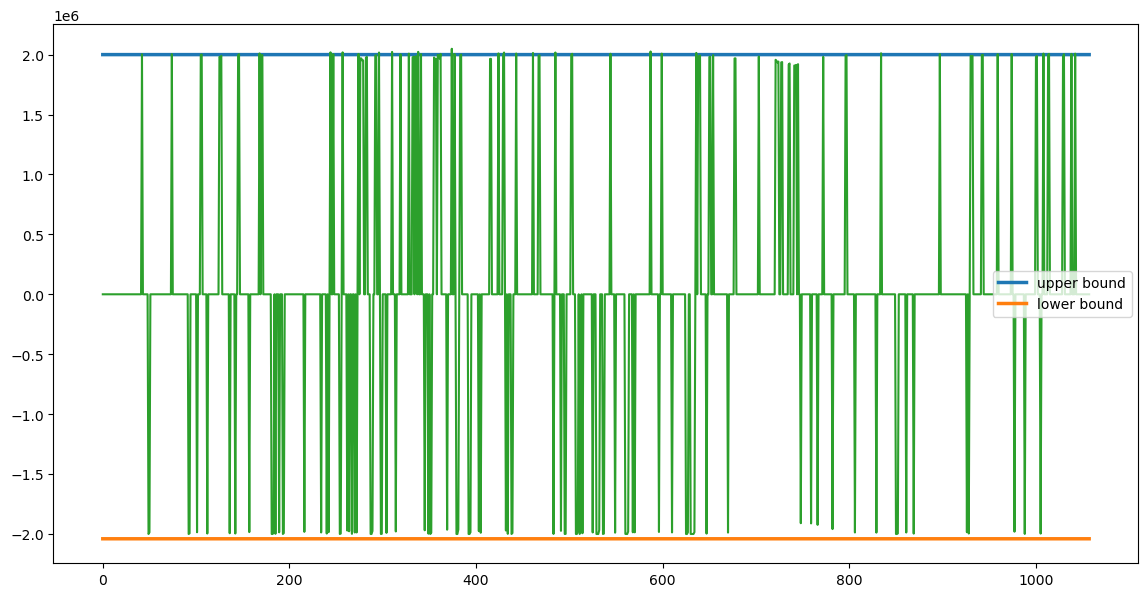

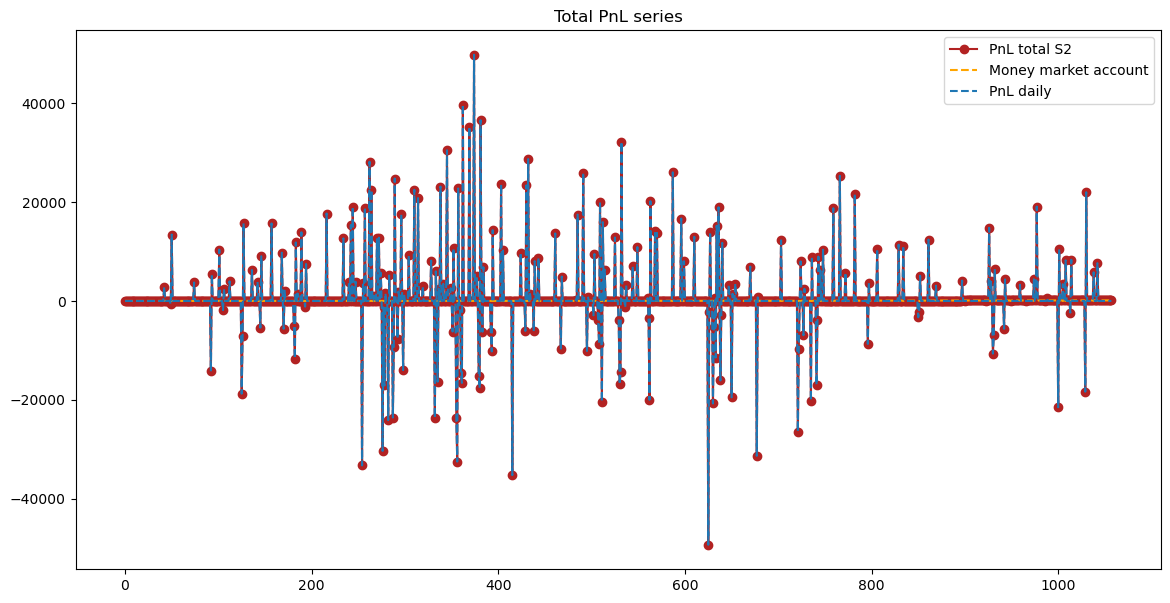

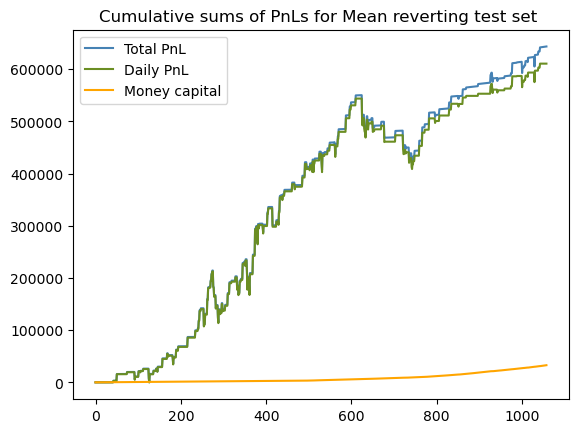

0.06888617958791515


In [1562]:
theta_AR =holding_AR*train_set
daily_PnL_AR =splt_excess_return_train*theta_AR
daily_PnL_AR= np.nan_to_num(daily_PnL_AR)



downside_returns = np.minimum(daily_PnL_AR, 0)
SortinoRatio=daily_PnL_AR/np.std(downside_returns)
SR = np.mean(daily_PnL_AR)/np.std(daily_PnL_AR)
# print(np.mean(SortinoRatio))
print(SR,np.mean(SortinoRatio))
t=np.arange(0,len(train_set))

c1=[V0*L]*len(train_set)
c2=[-1.02*V0*L]*len(train_set)
plt.figure(figsize =(14,7))
plt.plot(t,c1,linewidth=2.5,label='upper bound')
plt.plot(t,c2,linewidth=2.5,label='lower bound')
plt.plot(t,theta_AR)
plt.legend()
plt.show()

money_capital_AR =[0]*len(train_set)

for i in range(0,len(train_set)):
    m = np.array(cash_AR[i])*(train_set_EFFR[i])
    money_capital_AR[i]=m

money_capital_AR= np.nan_to_num(money_capital_AR)
PnL_Total_AR=daily_PnL_AR+money_capital_AR


# daily or total


plt.figure(figsize =(14,7))
plt.plot(t,PnL_Total_AR,label='PnL total S2',marker='o',color='firebrick')
plt.plot(t,money_capital_AR,label='Money market account',linestyle='--',color='orange')
plt.plot(t,daily_PnL_AR,linestyle ='--',label='PnL daily')
plt.title("Total PnL series")
plt.legend()
plt.show()
# plt.figure(figsize =(5,7))
plt.plot(t,np.cumsum(PnL_Total_AR),label='Total PnL',color='steelblue')
plt.plot(t,np.cumsum(daily_PnL_AR),label='Daily PnL',color='olivedrab')
plt.plot(t,np.cumsum(money_capital_AR),label='Money capital',color ='orange')
plt.title("Cumulative sums of PnLs for Mean reverting test set ")
plt.legend()
plt.show()

error = mean_squared_error(ar_prediction, train_set)
print(error)


Turnover S1 and S2 525633656.7267767
Turnover per unit traded S1 and S2 14681870.459441807


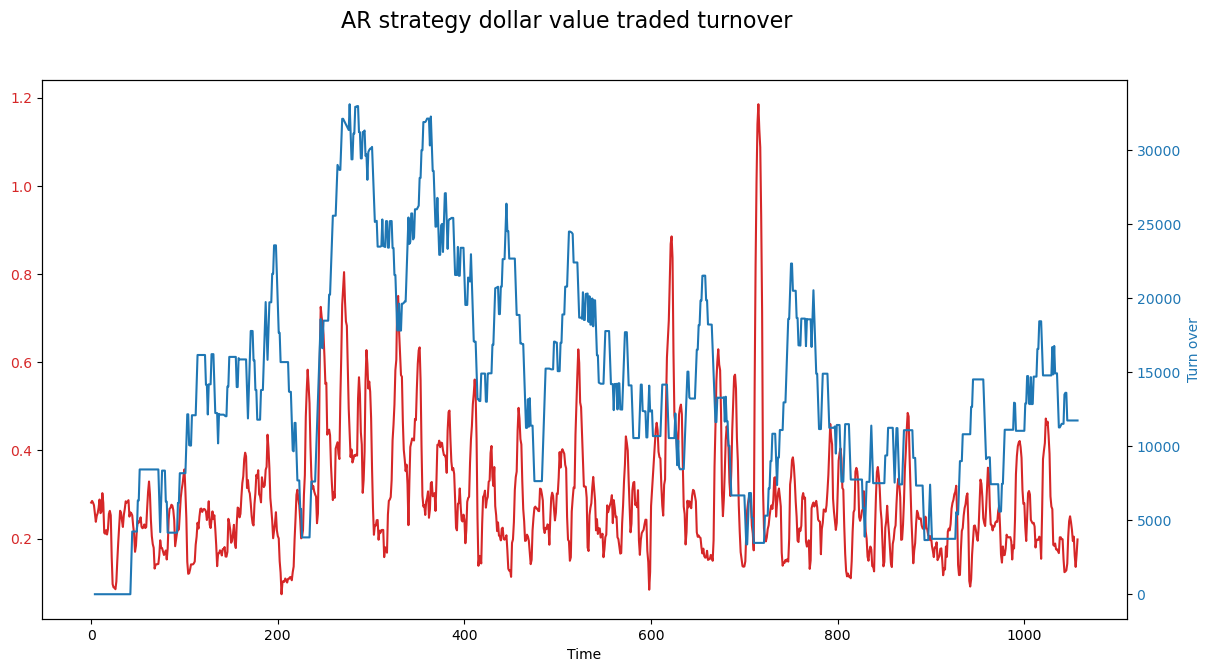

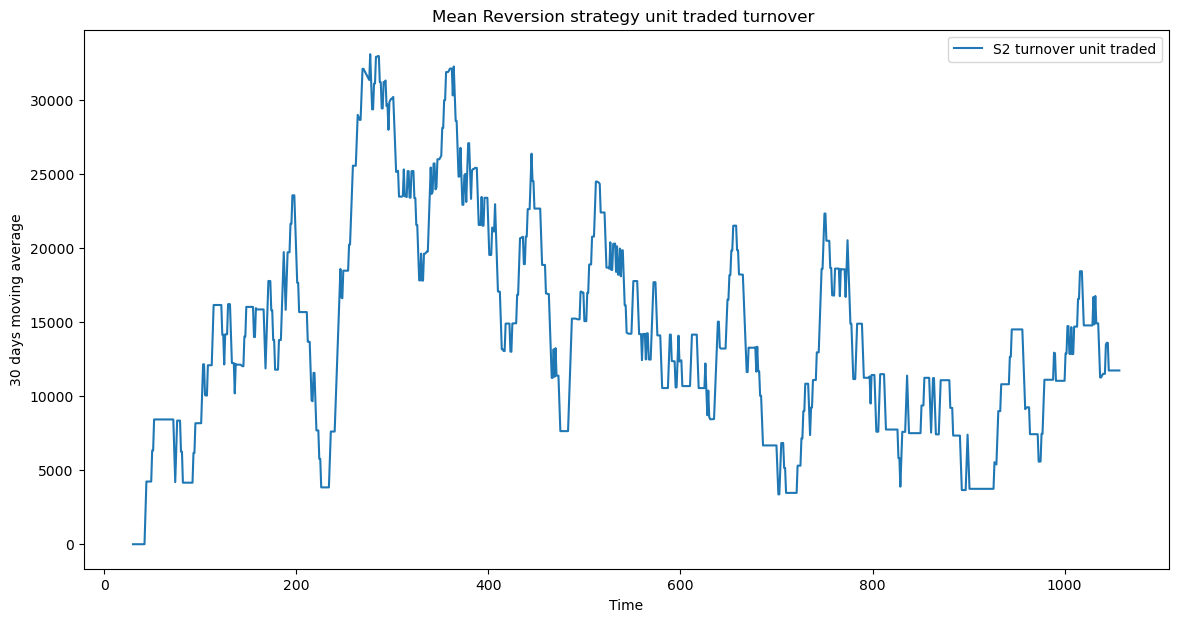

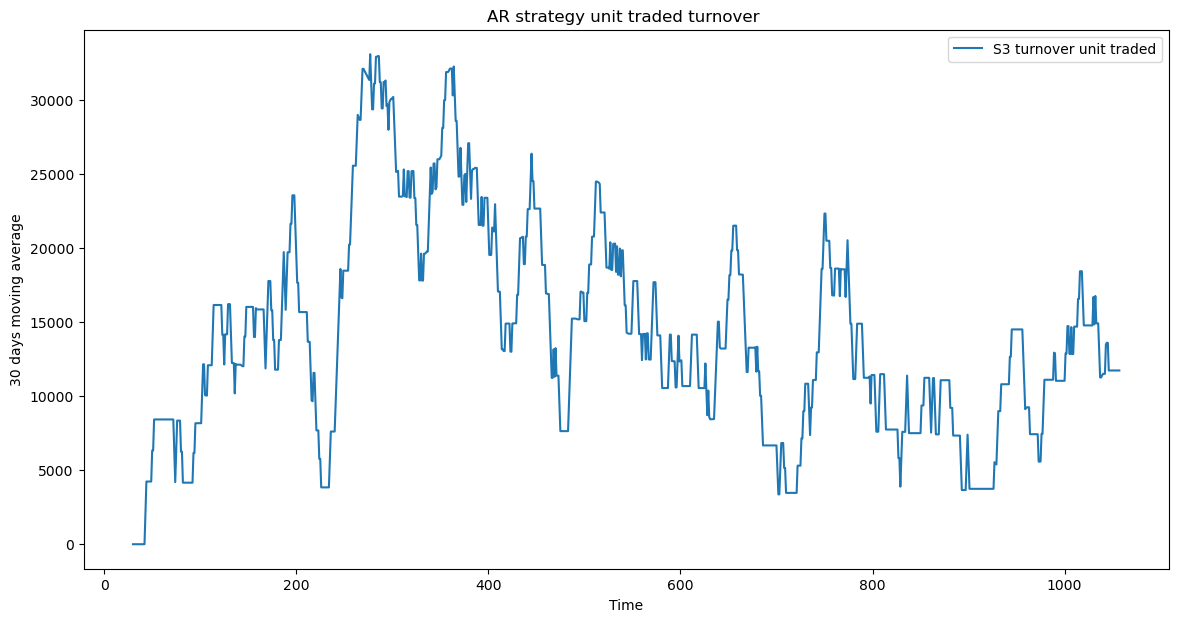

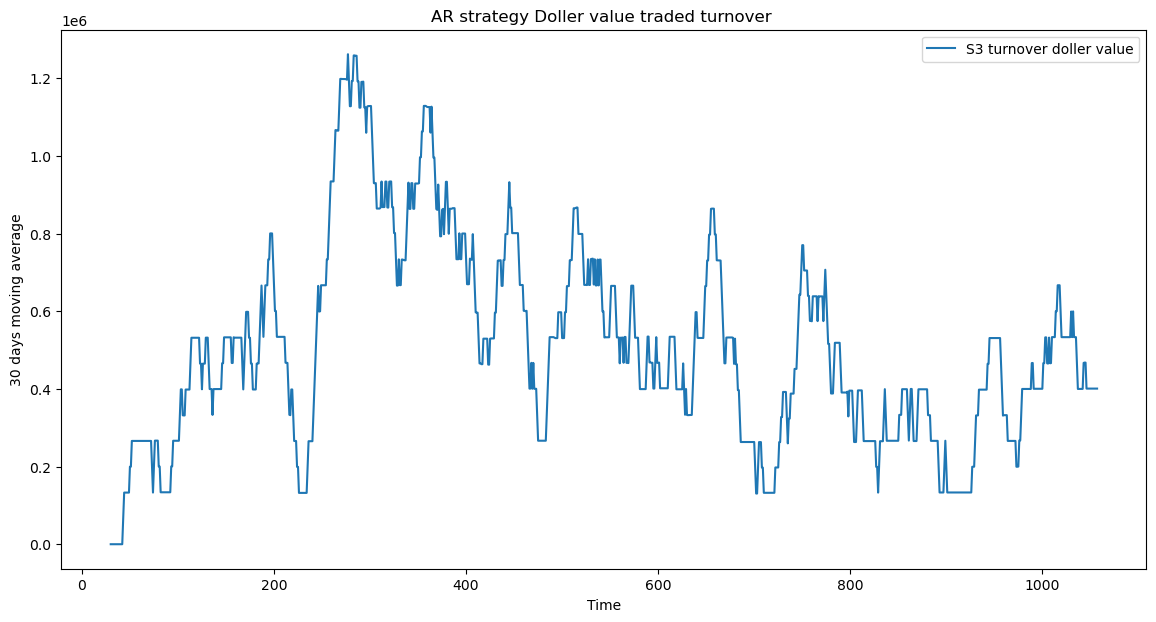

1.9903768053772122 99150.49972094098


In [1633]:
# AR turn over
t=np.arange(0,len(cash2))
turnover_S3=[0]
for i in range(1,len(holding_AR)):
    theta = np.abs((holding_AR[i]*train_set[i]-holding_AR[i-1]*train_set[i]))
    turnover_S3.append(theta)

print('Turnover S1 and S2',np.sum(turnover_S3))


# turn over and unite of trade
turnPerUnit_S3=[0]
for i in range(1,len(holding_AR)):
    theta = np.abs(holding_AR[i]-holding_AR[i-1])
    turnPerUnit_S3.append(theta)

# Normalise
# min_val = min(turnPerUnit_S1)
# max_val = max(turnPerUnit_S1)
# # turnPerUnit_S1 = [(x - min_val) / (max_val - min_val) for x in turnPerUnit_S1]

print('Turnover per unit traded S1 and S2',np.sum(turnPerUnit_S3))


# moving average of turn over
S1ma1=[0]*window
S1ma2=[0]*window
window =30
i=window
for i in range (i,len(cash3)):
    s1m1=np.sum([turnover_S3[i-x] for x in range(1,window+1)])/window
    s1m2=np.sum([turnPerUnit_S3[i-x] for x in range(1,window+1)])/window 
    S1ma1.append(s1m1)
    S1ma2.append(s1m2)




fig, ax1 = plt.subplots(figsize =(14,7))

color = 'tab:red'

t=np.arange(len(train_set))


ax1.set_xlabel('Time')
ax1.set_ylabel('', color=color)
ax1.plot(t[:len(train_set)], rolling_volatility[:len(train_set)], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.suptitle('AR strategy dollar value traded turnover', fontsize=16) 
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Turn over', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], S1ma2[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Plot unit turn over
plt.figure(figsize =(14,7))
plt.plot(np.arange(len(S1ma1))[30:],S1ma2[30:],label='S2 turnover unit traded')

plt.title('Mean Reversion strategy unit traded turnover ')
plt.xlabel('Time')
plt.ylabel("30 days moving average")
plt.legend()
plt.show()


# Plot unit turn over
plt.figure(figsize =(14,7))
plt.plot(np.arange(len(S1ma2))[30:],S1ma2[30:],label='S3 turnover unit traded')

plt.title('AR strategy unit traded turnover ')
plt.xlabel('Time')
plt.ylabel("30 days moving average")
plt.legend()
plt.show()

# Plot value turn over
plt.figure(figsize =(14,7))
# plt.plot(t,S1ma2,label='S1 turnover unit traded')
plt.plot(np.arange(len(S1ma2))[30:],S1ma1[30:],label='S3 turnover doller value')
plt.title('AR strategy Doller value traded turnover ')
plt.xlabel('Time')
plt.ylabel("30 days moving average")
plt.legend()
plt.show()





window =len('train_set')
data ={'data':daily_PnL_AR}
df=pd.DataFrame(data)
Roll_Max = df['data'].rolling(window, min_periods=1).max()
Roll_min = df['data'].rolling(window, min_periods=1).min()
max_drawdown =(np.max(Roll_Max)-np.min(Roll_min))

# maximum draw down\
calmar_ratio = max_drawdown/np.max(Roll_Max)
print(calmar_ratio,max_drawdown)

In [1564]:
# AR test set
time_window = 30

S=test_set.copy()
ar_prediction = test_set.copy()

holding_AR1 = np.zeros(np.shape(S))
cash_AR = [V0*L]*len(S)
buy = False
short = False
short_Price=0
constrain=V0*L
for i, x in enumerate(S[:-1], 0):
    if i>=time_window:
        X = S[0:i]
        train = X
        # train autoregression
        model = AutoReg(train,1)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
        ar_prediction[i] = predictions.iloc[0]

    if buy == False and short == False:
        if ar_prediction[i] > 1.01*x: 
            if cash_AR[i]<=constrain:
                holding_AR1[i+1] = cash_AR[i]/x 
                cash_AR[i+1] = 0
            else:
                holding_AR1[i+1] = constrain/x 
                cash_AR[i+1] = cash_AR[i]-constrain
            buy = True
        elif ar_prediction[i] < 0.99*x:
            if cash_AR[i]<=constrain:
                holding_AR1[i+1] = -(cash_AR[i]/x ) 
                cash_AR[i+1] = 0
            else:
                holding_AR1[i+1] = -(constrain/x )
                cash_AR[i+1] = cash_AR[i]-constrain
            short_Price=x
            short = True
        else:
            holding_AR1[i+1] = holding_AR1[i]
            cash_AR[i+1] = cash_AR[i]
    elif buy:   
        if ar_prediction[i] < x:
            cash_AR[i+1] = holding_AR1[i]*x + cash_AR[i]
            holding_AR1[i+1] = 0
            buy = False
        else:
            if holding_AR1[i]*x<= constrain:
                holding_AR1[i]=constrain/x
                cash_AR[i]=x*(holding_AR1[i]-holding_AR1[i-1])+cash_AR[i-1]
            holding_AR1[i+1] = holding_AR1[i]
            cash_AR[i+1] = cash_AR[i]
    elif short:
        if ar_prediction[i] >= x:
            cash_AR[i+1] = np.abs(holding_AR1[i])*(2*short_Price-x)+cash_AR[i]
            holding_AR1[i+1] = 0
            short_Price=0
            short = False
        else:
            if np.abs(holding_AR1[i])*x > constrain:
                
                holding_AR1[i]=-(constrain/x)
                cash_AR[i] = np.abs(holding_AR1[i-1]-holding_AR1[i])*(2*short_price-x)+cash_AR[i-1]
            holding_AR1[i+1] = holding_AR1[i]
            cash_AR[i+1] = cash_AR[i]
        


/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yuiisyue/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, Datetime

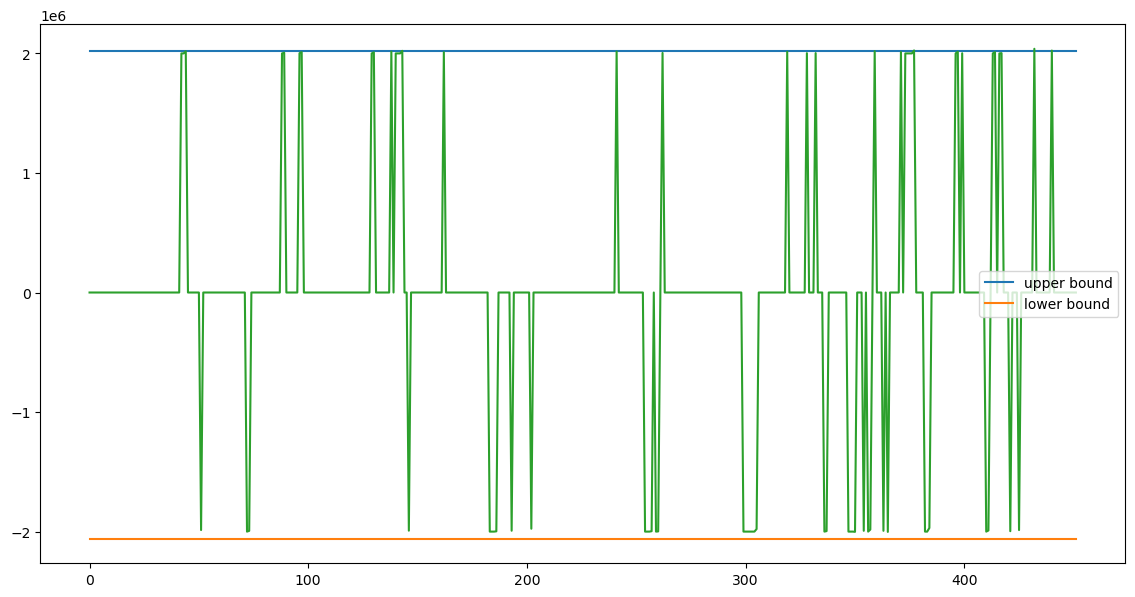

-0.028189117162682565
0.059488823824402445


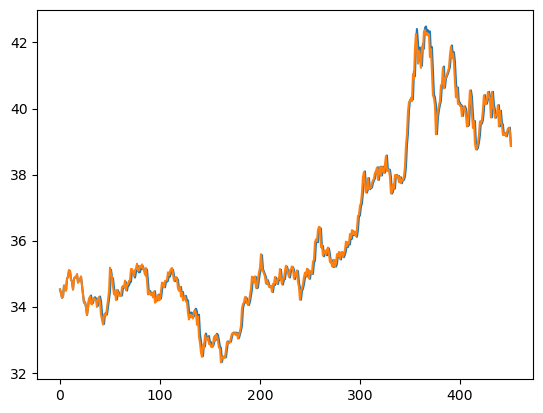

93384.28938525403 1.874624173374555


In [1598]:
theta_AR2 =holding_AR1*test_set
daily_PnL_AR_test =splt_excess_return_test*theta_AR2

t=np.arange(0,len(test_set))

downside_returns = np.minimum(daily_PnL_AR, 0)
SortinoRatio=daily_PnL_AR/np.std(downside_returns)

# print(np.mean(SortinoRatio))


c1=[1.01*V0*L]*len(test_set)
c2=[-1.03*V0*L]*len(test_set)
plt.figure(figsize =(14,7))
plt.plot(t,c1,label='upper bound')
plt.plot(t,c2,label='lower bound')
plt.plot(t,theta_AR2)
plt.legend()
plt.show()

money_capital_AR =[0]*len(test_set)

for i in range(0,len(test_set)):
    m = np.array(cash_AR[i])*(test_set_EFFR[i])
    money_capital_AR[i]=m

money_capital_AR= np.nan_to_num(money_capital_AR)
# PnL_Total_AR=daily_PnL_AR_test+money_capital_AR

SR = np.mean(daily_PnL_AR_test)/np.std(daily_PnL_AR_test)
# daily or total
print(SR)

error = mean_squared_error(ar_prediction, test_set)
print(error)
plt.plot(t,ar_prediction)
plt.plot(t,test_set)
plt.show()



window =len('train_set')
data ={'data':daily_PnL_AR}
df=pd.DataFrame(data)
Roll_Max = df['data'].rolling(window, min_periods=1).max()
Roll_min = df['data'].rolling(window, min_periods=1).min()
max_drawdown =(np.max(Roll_Max)-np.min(Roll_min))

window =len('test_set')
data ={'data':daily_PnL_AR_test}
df=pd.DataFrame(data)
Roll_Maxt = df['data'].rolling(window, min_periods=1).max()
Roll_min = df['data'].rolling(window, min_periods=1).min()
max_drawdown =(np.max(Roll_Max)-np.min(Roll_min))

# maximum draw down\
calmar_ratio = max_drawdown/np.max(Roll_Max)
print(max_drawdown,calmar_ratio)

-0.02818911716268257


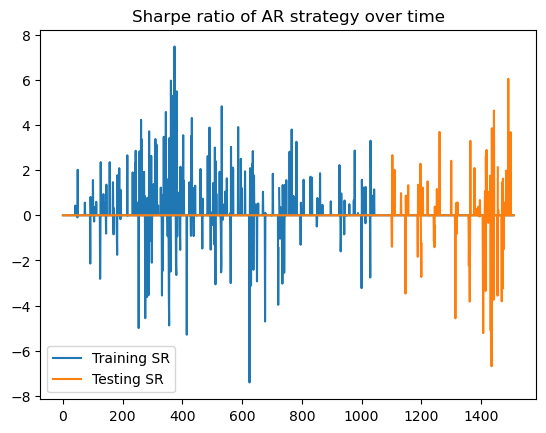

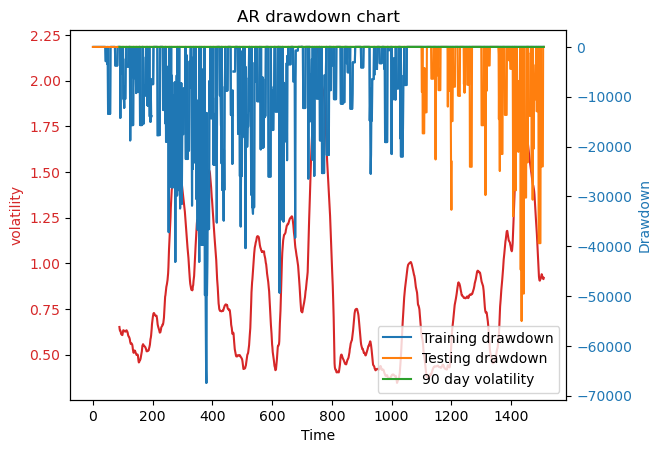

In [1600]:
daily_PnL_AR_test =splt_excess_return_test*theta_AR2
daily_PnL_AR=splt_excess_return* theta_AR
SR = daily_PnL_AR/np.std(daily_PnL_AR)
SR_test= daily_PnL_AR_test/np.std(daily_PnL_AR_test)
print(np.mean(SR_test))
s1=[0]*len(splt)
s2=[0]*len(splt)
for i in range(len(splt)):
    if i<len(train_set):
        s2[i]=0
        s1[i]=SR[i]
    else:
        s1[i]=0
        s2[i]=SR_test[i-len(train_set)-1]

t=np.arange(0,len(splt))
plt.plot(t,s1,label='Training SR')
plt.plot(t,s2,label='Testing SR')
plt.title('Sharpe ratio of AR strategy over time')
plt.legend()
plt.show()

dd1=[0]*len(splt)
dd2=[0]*len(splt)
for i in range(len(splt)):
    if i<len(train_set):
        dd2[i]=0
        dd1[i]=daily_PnL_AR[i]-Roll_Max[i]
    else:
        dd1[i]=0
        dd2[i]=(daily_PnL_AR_test[i-len(train_set)-1] -Roll_Maxt[i-len(train_set)-1])


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('volatility', color=color)
ax1.plot(np.arange(len(splt))[89:], rolling_volatility, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Drawdown', color=color)  # we already handled the x-label with ax1
ax2.plot(t[4:], dd1[4:], color=color)
ax2.tick_params(axis='y', labelcolor=color)
t=np.arange(0,len(splt))


t=np.arange(0,len(splt))
plt.plot(t,dd1,label='Training drawdown')
plt.plot(t,dd2,label='Testing drawdown')
plt.plot(t,roll_vo,label='90 day volatility')
plt.xlabel('Time')
plt.title('AR drawdown chart')
plt.legend()
plt.show()